In [1]:
import sys
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
sys.path.append('/mnt/c/MyPrograms/Python/_lib')
sys.path.append('/home/zinovyev/pyvenn')
print(sys.path)

['/mnt/c/MyPrograms/Python/iPC', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/mnt/c/MyPrograms/Python/_lib', '/home/zinovyev/pyvenn']


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
import seaborn as sns
from scipy import sparse
from lifelines.statistics import logrank_test

def ismember(A, B):
    dct = {}
    for s,i in enumerate(B):
        dct[i] = s
    return [ dct[a] for a in A ]


In [164]:
folder = '/mnt/c/Users/zinovyev/Google Drive/iPC_CURIE/Neuroblastoma_multiomics/NB_multii_omics_amc/harmonized/patient_ids/'
folder_analysis = '/mnt/c/Users/zinovyev/Google Drive/iPC_CURIE/Neuroblastoma_multiomics/NB_multii_omics_amc/harmonized/data_analysis/'
#folder = '/mnt/c/Users/zinovyev/Google Drive/iPC_CURIE/Neuroblastoma_multiomics/NB_multii_omics_amc/harmonized/data_analysis/ica_decompositions/'
#fn = 'NBAMC_expression_u133int_logx1.txt'
fn = 'NBAMC_copynumber.txt'
#fn = 'NBAMC_methylation.txt'
#fn = 'NBAMC_expression_exon_logx1.txt'
#fn = 'NBAMC_multiICA.txt'

patient_info_fn = 'patient_sample_info.txt'

dfE = pd.read_csv(folder+fn,sep='\t',index_col=False)

remove_last_column = True

if remove_last_column:
    Xe = dfE[dfE.columns[1:-1]].to_numpy()
    samplenames = np.array(list(dfE.columns[1:-1]))
    dfE = dfE[dfE.columns[:-1]]
else:
    Xe = dfE[dfE.columns[1:]].to_numpy()
    samplenames = np.array(list(dfE.columns[1:]))
    
display(dfE)
genenames = np.array(list(dfE.GENE))
print(genenames)

gene_prop = pd.read_csv('/mnt/c/Datas/BIODICA_GUI/knowledge/geneproperties/gene_pos.txt',sep='\t')
display(gene_prop)
gns_prop = list(gene_prop.GENE)
chr_num = list(gene_prop.CHR)
gene_start = list(gene_prop.START)
gene_end = list(gene_prop.START)
missing_genes = list(set(genenames)-set(gns_prop))
print('N missing genes:',len(missing_genes))
gns_prop = gns_prop + missing_genes
print(len(gns_prop))
good_chromosomes = ['-1','1','10','11','12','13','14','15','16','17','18','19','2','20','21','22','3','4','5','6','7','8','9','X','Y']
chr_num = chr_num + [0]*len(missing_genes)
gene_start = gene_start + [0]*len(missing_genes)
gene_end = gene_end + [0]*len(missing_genes)
gene_start_millions = ((np.array(gene_start).astype(np.float)/1000000).astype(np.int))
for i,c in enumerate(chr_num):
    if not c in good_chromosomes:
        chr_num[i] = '0'
    if c=='X':
        chr_num[i] = '23'
    if c=='Y':
        chr_num[i] = '24'

inds = ismember(genenames,gns_prop)
print('len(inds)',len(inds),inds[:10],np.array(gns_prop)[inds[:10]])


chr_num_data = np.array(chr_num)[inds]
gene_start_data = np.array(gene_start)[inds]
gene_pos_data = np.zeros(len(chr_num_data))
gene_start_millions_data = gene_start_millions[inds]

chr_num_data[chr_num_data=='X'] = '23'
chr_num_data[chr_num_data=='Y'] = '24'
chr_num_data = np.array([int(c) for c in chr_num_data])

df_ICA_exp = pd.read_csv('/mnt/c/Users/zinovyev/Google Drive/iPC_CURIE/Neuroblastoma_multiomics/NB_multii_omics_amc/harmonized/data_analysis/ica_decompositions/NBAMC_expression_u133int_logx1_ica_S.xls',sep='\t')
df_ICA_exp = df_ICA_exp[df_ICA_exp.columns[:-1]]
genenames_exp = df_ICA_exp['PROBE']
df_ICA = pd.read_csv(folder+'../data_analysis/ica_decompositions/'+fn[:-4]+'_ica_S.xls',sep='\t')
display(df_ICA)

print('chr_num_data=',chr_num_data)

good_chromosomes = np.unique(chr_num_data)
print('good_chromosomes=',good_chromosomes)

chr_lengths = []
for c in good_chromosomes:
    ind_c = np.where(np.array(chr_num_data)==c)[0]
    l = np.max(np.array(np.array(gene_end)[inds])[ind_c])
    chr_lengths.append(l)
    print(c,l)
    
cs = np.cumsum(chr_lengths)
for i in range(len(gene_pos_data)):
    gene_pos_data[i] = gene_start_data[i] + cs[chr_num_data[i]]
    
patient_info = pd.read_csv(folder+patient_info_fn,sep='\t')
patient_list = list(patient_info.Patient)
inds = ismember(samplenames,patient_list)
patient_info = patient_info.iloc[inds]
display(patient_info)

,GENE,N041,N062,N085,N089,N097,N106,N127,N130,N159,...,N752,N753,N759,N764,N770,N772,N774,N783,N789,N790
0,A1BG,0.296,0.027,-0.210,-0.262,0.185,-0.114,-0.274,-0.178,0.155,...,-0.304,0.115,-0.292,0.086,0.251,-0.014,0.179,0.031,0.118,-0.133
1,A1CF,-0.342,0.394,0.000,-0.588,-0.094,-0.355,-0.333,0.062,-0.133,...,-0.335,-0.142,0.039,-0.302,-0.276,-0.066,-0.302,-0.490,-0.225,-0.107
2,A2M,0.152,0.033,-0.050,-0.048,-0.039,-0.186,0.090,0.030,-0.150,...,0.348,-0.112,0.088,0.085,0.238,-0.067,-0.295,-0.041,0.059,0.289
3,A2ML1,0.259,0.033,-0.123,-0.048,0.030,-0.186,0.090,-0.054,-0.065,...,0.346,-0.072,0.088,0.085,0.238,-0.075,-0.295,-0.041,0.059,0.205
4,A4GALT,0.017,0.418,-0.186,0.063,0.131,-0.234,-0.342,-0.873,0.076,...,0.334,0.050,0.105,-0.356,0.337,0.028,-0.238,0.496,-0.186,-0.291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17887,ZYG11A,-0.183,0.034,-0.064,-0.639,0.022,0.285,-0.351,-0.701,0.008,...,0.056,-0.075,0.106,-0.198,-0.131,-0.001,-0.245,0.099,0.047,0.052
17888,ZYG11B,-0.183,0.034,-0.064,-0.639,0.022,0.285,-0.351,-0.701,-0.001,...,0.056,-0.070,0.106,-0.198,-0.131,-0.001,-0.245,0.099,0.049,0.065
17889,ZYX,0.707,0.041,0.066,0.058,0.341,0.577,0.485,-0.279,0.074,...,0.396,-0.048,0.050,0.383,0.429,0.367,0.389,0.169,0.507,0.090
17890,ZZEF1,-0.117,0.406,0.151,-0.039,0.050,-0.261,0.474,-0.039,0.047,...,0.089,0.014,0.093,0.151,0.112,-0.005,0.428,0.481,0.300,0.387


['A1BG' 'A1CF' 'A2M' ... 'ZYX' 'ZZEF1' 'ZZZ3']


,GENE,CHR,START,END
0,5_8S_rRNA,KI270442.1,217250,217401
1,5_8S_rRNA,GL000220.1,155997,156149
2,5_8S_rRNA,KI270733.1,173956,174108
3,5_8S_rRNA,21,8256781,8256933
4,5_8S_rRNA,22,11249809,11249959
...,...,...,...,...
45928,ZYX,CHR_HG708_PATCH,143381295,143391111
45929,ZYX,7,143381295,143391111
45930,ZYXP1,8,137424904,137425021
45931,ZZEF1,17,4004445,4143030


N missing genes: 1280
47213
len(inds) 17892 [45, 47, 48, 50, 55, 56, 58, 59, 61, 63] ['A1BG' 'A1CF' 'A2M' 'A2ML1' 'A4GALT' 'A4GNT' 'AAAS' 'AACS' 'AADAC'
 'AADACL2']


/home/zinovyev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/zinovyev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.

,PROBE,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,...,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,Unnamed: 21
0,A1BG,-0.0466,-0.4224,0.2553,3.4219,0.2933,-0.3369,0.2013,0.1091,-0.2936,...,0.0752,-0.0234,-1.0289,0.0015,0.9892,-1.4270,-0.9980,-0.2215,0.1141,NaN
1,A1CF,-0.1265,0.2275,0.1784,-0.6502,-0.4189,0.4618,0.6420,3.4752,-0.8903,...,-0.4946,0.3071,0.0574,0.1078,-1.1549,-0.7912,0.0764,0.1546,-0.2693,NaN
2,A2M,-0.0367,-0.3542,-0.0005,-0.0618,-0.5726,0.1713,-0.2666,-0.7445,-0.4754,...,-0.0659,0.2373,0.2027,-0.1077,-1.1532,0.0494,0.0220,0.3307,2.8992,NaN
3,A2ML1,0.1046,-0.4503,0.0885,0.0135,-0.6610,0.1423,-0.3794,-0.6281,-0.3102,...,-0.1840,0.2293,0.3616,0.0103,-0.1892,0.0344,0.1850,0.3307,2.8135,NaN
4,A4GALT,-1.8282,-0.3572,-1.2972,-0.1954,-0.2738,-2.0969,-0.5416,-1.0267,-1.9865,...,-0.4522,0.0468,-0.0395,0.1862,0.7649,1.6414,0.9778,-0.1502,1.2958,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17887,ZYG11A,-0.8390,0.1452,-0.4442,-1.0980,-0.5514,-1.2791,-0.2560,0.4424,0.2135,...,0.1332,0.3911,-2.3095,-0.4822,-0.0792,-0.1866,-1.0733,-3.0084,1.6444,NaN
17888,ZYG11B,-0.8783,0.1021,-0.4840,-1.1207,-0.5924,-1.2573,-0.2861,0.4697,0.2349,...,0.1604,0.4300,-2.2684,-0.4993,-0.2075,-0.1586,-1.1196,-2.9919,1.6067,NaN
17889,ZYX,0.0749,-0.7523,0.1905,-0.6270,-0.5474,-0.1185,-0.4205,-1.0620,4.6352,...,0.0593,0.3746,0.7495,-0.7644,1.6052,-0.1796,0.1188,0.3669,-0.6280,NaN
17890,ZZEF1,0.7795,-0.2142,0.4194,-0.1506,-0.5515,-0.1405,0.6155,-1.5269,-0.4440,...,-1.3349,1.6661,-0.0610,1.9313,-0.2832,0.2606,4.6899,-0.4707,0.0005,NaN


chr_num_data= [19 10 12 ...  7 17  1]
good_chromosomes= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
0 113667219
1 248906196
2 241849884
3 198153287
4 190173774
5 181367268
6 170575295
7 159028175
8 145052465
9 138217068
10 133623895
11 134378504
12 133181409
13 114281601
14 105526583
15 101922042
16 90056566
17 83079609
18 80157232
19 58561931
20 64255695
21 46635595
22 50767501
23 155997696


,Patient,SampleType,AgeGroup,AgeGroup2,Alive,AlivePlus,Death_cause,Hospital,NTI_age_days,NTI_age_month,...,cg_mycn,chemo,chromotrypsis,inss,institute,irradiation,lcstate,primary_site,surgery,cgcgh_tmev_p_st4_rest_subcluster_jk
251,N041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,non-amp,no,nd,st2,amsterdam,no,dod,adr_gland,nd,low2
0,N062,T1,<1,<=1Y,YES,>=5Y,nd,EKZ,37,1,...,non-amp,no,nd,st2,amsterdam,no,ned,adr_gland,yes,low2
48,N085,T1,<1,<=1Y,YES,>=5Y,nd,EKZ,104,3,...,non-amp,no,nd,st4s,amsterdam,no,ned,adr_gland,no,low1
30,N089,T1,>=1,1-2Y,NO,NO,Tumor,RADBOUD,538,18,...,amp,yes,nd,st4,amsterdam,no,dod,adr_gland,yes,sub1
7,N097,T1,<1,<=1Y,YES,>=5Y,nd,EKZ,276,9,...,non-amp,no,nd,st2,amsterdam,no,ned,paravert_thorax,yes,low2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,N772,T1,>18_months,>2Y,YES,0-2Y,nd,EKZ,1107,36,...,non-amp,0,0,st4,0,0,0,0,0,sub2
263,N774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,non-amp,0,0,st4,0,0,0,0,0,sub3b
264,N783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,amp,0,yes,st4,0,0,0,0,0,sub3c
265,N789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,non-amp,0,0,st1,0,0,0,0,0,low2


In [346]:
for s in samplenames:
    if not s in patient_list:
        print(s)

N701.1


In [16]:
patient_info = pd.read_csv(folder+patient_info_fn,sep='\t')
patient_list = list(patient_info.Patient)
print(set(samplenames)-set(patient_list))
inds = ismember(samplenames,patient_list)
patient_info = patient_info.iloc[inds]
display(patient_info)

set()


,Patient,SampleType,AgeGroup,AgeGroup2,Alive,AlivePlus,Death_cause,Hospital,NTI_age_days,NTI_age_month,...,cg_mycn,chemo,chromotrypsis,inss,institute,irradiation,lcstate,primary_site,surgery,cgcgh_tmev_p_st4_rest_subcluster_jk
251,N041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,non-amp,no,nd,st2,amsterdam,no,dod,adr_gland,nd,low2
0,N062,T1,<1,<=1Y,YES,>=5Y,nd,EKZ,37,1,...,non-amp,no,nd,st2,amsterdam,no,ned,adr_gland,yes,low2
48,N085,T1,<1,<=1Y,YES,>=5Y,nd,EKZ,104,3,...,non-amp,no,nd,st4s,amsterdam,no,ned,adr_gland,no,low1
30,N089,T1,>=1,1-2Y,NO,NO,Tumor,RADBOUD,538,18,...,amp,yes,nd,st4,amsterdam,no,dod,adr_gland,yes,sub1
7,N097,T1,<1,<=1Y,YES,>=5Y,nd,EKZ,276,9,...,non-amp,no,nd,st2,amsterdam,no,ned,paravert_thorax,yes,low2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,N772,T1,>18_months,>2Y,YES,0-2Y,nd,EKZ,1107,36,...,non-amp,0,0,st4,0,0,0,0,0,sub2
263,N774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,non-amp,0,0,st4,0,0,0,0,0,sub3b
264,N783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,amp,0,yes,st4,0,0,0,0,0,sub3c
265,N789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,non-amp,0,0,st1,0,0,0,0,0,low2


In [17]:
ginds =np.argsort(-np.var(Xe,axis=1))
mostvargenes = ginds[:5000]

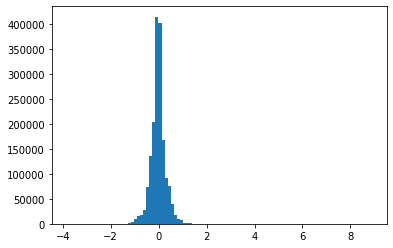

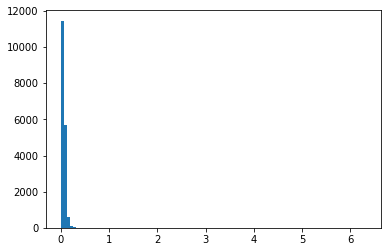

In [18]:
plt.hist(Xe.flatten(),bins=100)
plt.show()
plt.hist(np.var(Xe,axis=1),bins=100)
plt.show()

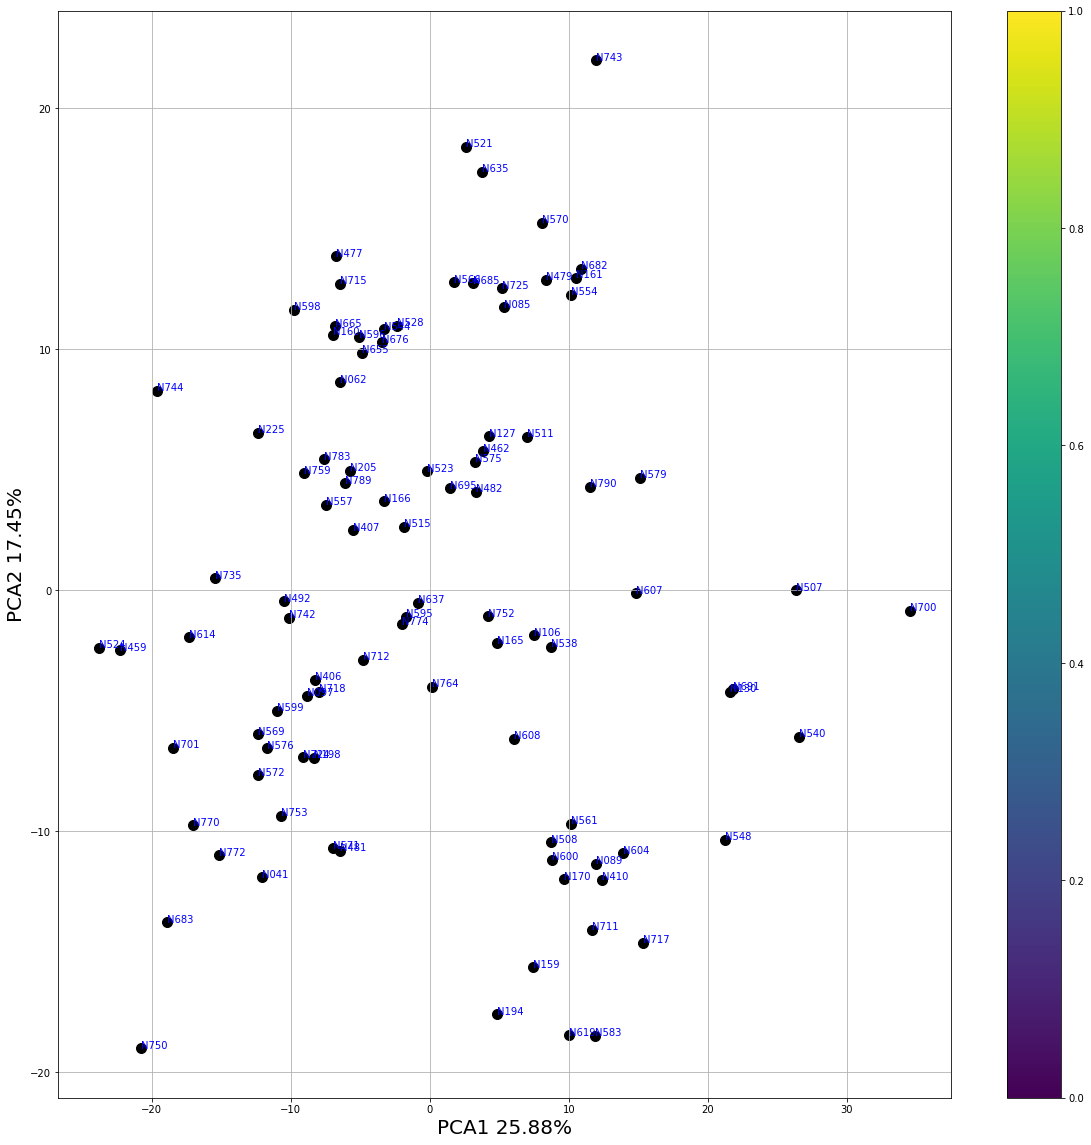

In [19]:
Xemv = Xe[mostvargenes,:]
reducer = PCA()
X1p_PCA = reducer.fit_transform(Xemv.T)
plt.figure(figsize=(20,20))
plt.scatter(X1p_PCA[:,0],X1p_PCA[:,1],c='k',s=100)
for k,t in enumerate(samplenames):
    plt.text(X1p_PCA[k,0],X1p_PCA[k,1],t,color='blue')
plt.title('')
plt.xlabel('PCA1 {:2.2f}%'.format(reducer.explained_variance_ratio_[0]*100),fontsize=20)
plt.ylabel('PCA2 {:2.2f}%'.format(reducer.explained_variance_ratio_[1]*100),fontsize=20)
plt.colorbar()
plt.grid('on')
plt.show()

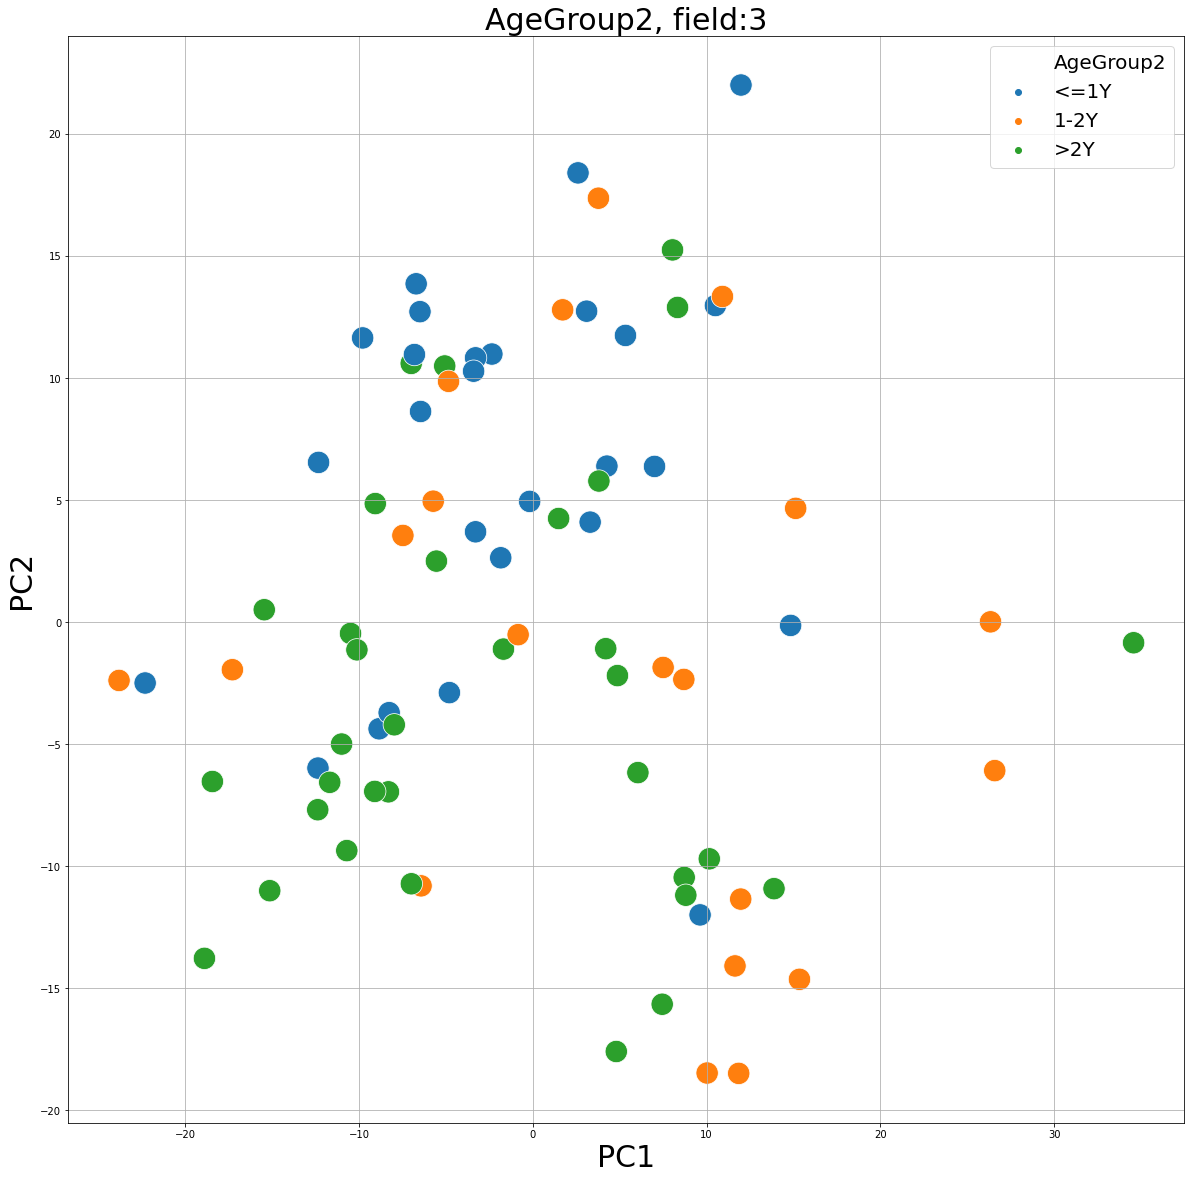

In [20]:
df1 = patient_info.copy()
df1['PC1'] = X1p_PCA[:,0]
df1['PC2'] = X1p_PCA[:,1]
fd = 3
plt.figure(figsize=(20,20))
sns.scatterplot(data=df1,x='PC1',y='PC2',hue=df1.columns[fd],s=500)
plt.legend(fontsize=20)
plt.xlabel('PC1',fontsize=30)
plt.ylabel('PC2',fontsize=30)
plt.title(f'{df1.columns[fd]}, field:{fd}',fontsize=30)
plt.grid('on')
plt.show()

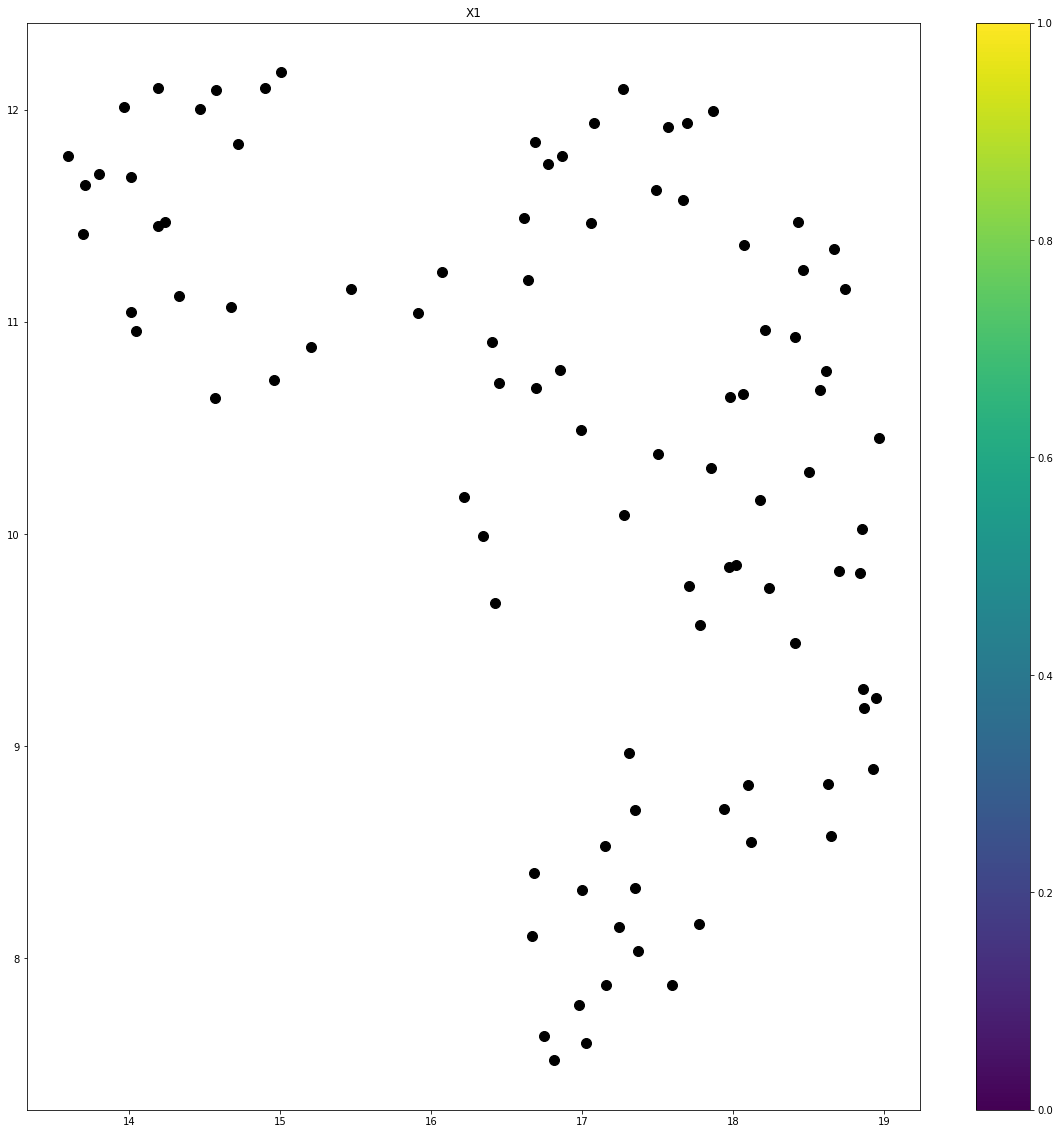

In [21]:
metric = 'euclidean'
reducer = umap.UMAP(metric=metric)
X1p_UMAP = reducer.fit_transform(Xemv.T)
plt.figure(figsize=(20,20))
plt.scatter(X1p_UMAP[:,0],X1p_UMAP[:,1],c='k',s=100)
plt.title('X1')
plt.colorbar()
plt.show()


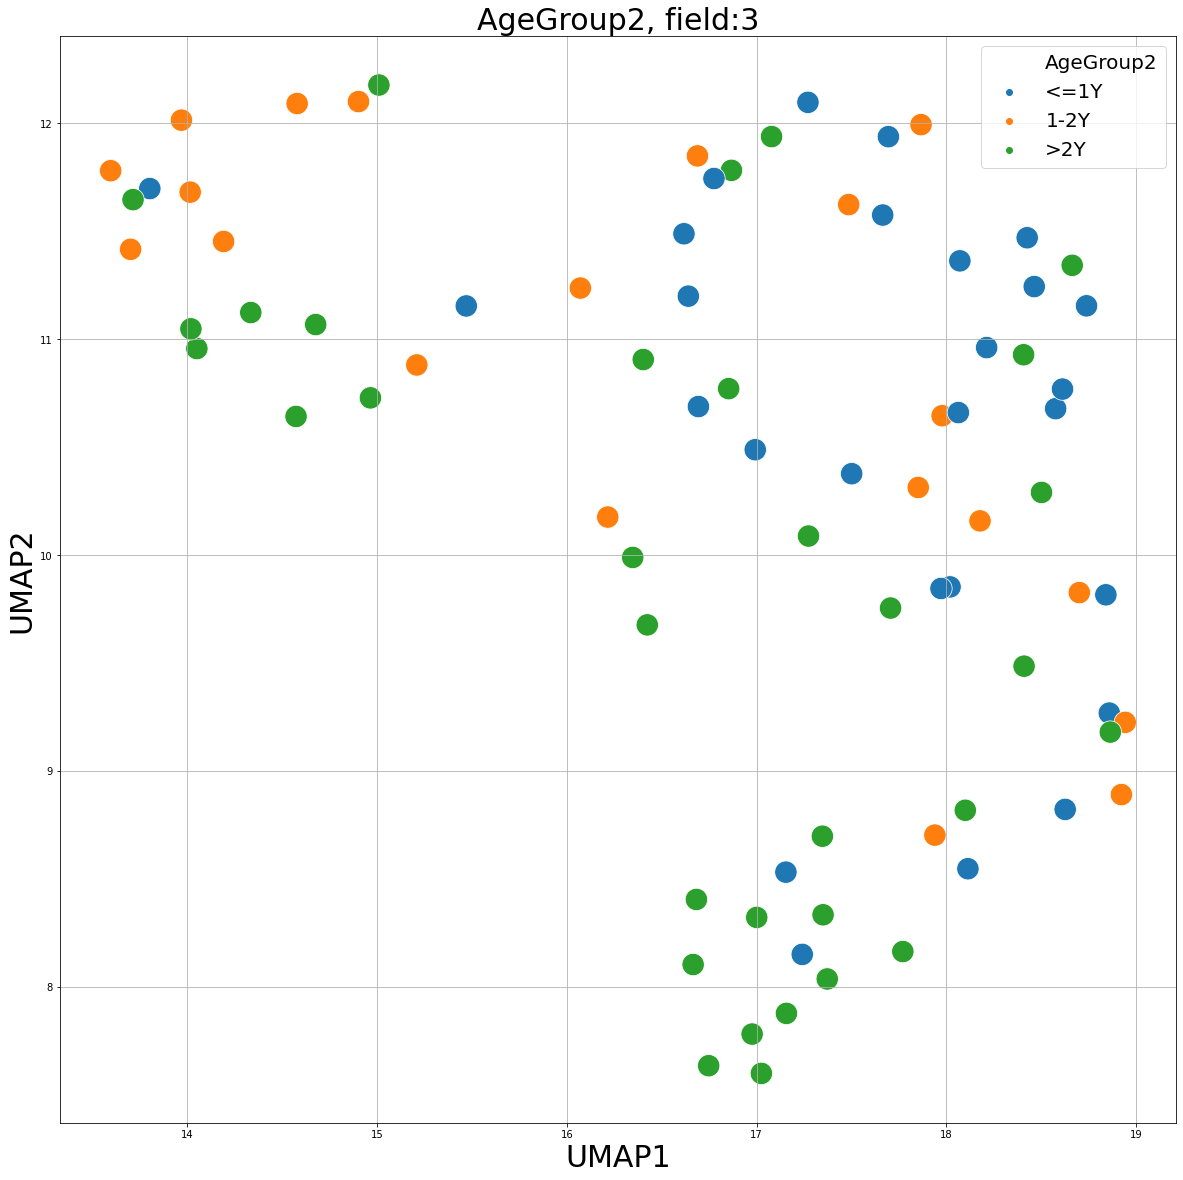

In [22]:
df1 = patient_info.copy()
df1['UMAP1'] = X1p_UMAP[:,0]
df1['UMAP2'] = X1p_UMAP[:,1]
fd = 3
plt.figure(figsize=(20,20))
sns.scatterplot(data=df1,x='UMAP1',y='UMAP2',hue=df1.columns[fd],s=500)
plt.legend(fontsize=20)
plt.xlabel('UMAP1',fontsize=30)
plt.ylabel('UMAP2',fontsize=30)
plt.title(f'{df1.columns[fd]}, field:{fd}',fontsize=30)
plt.grid('on')
plt.show()

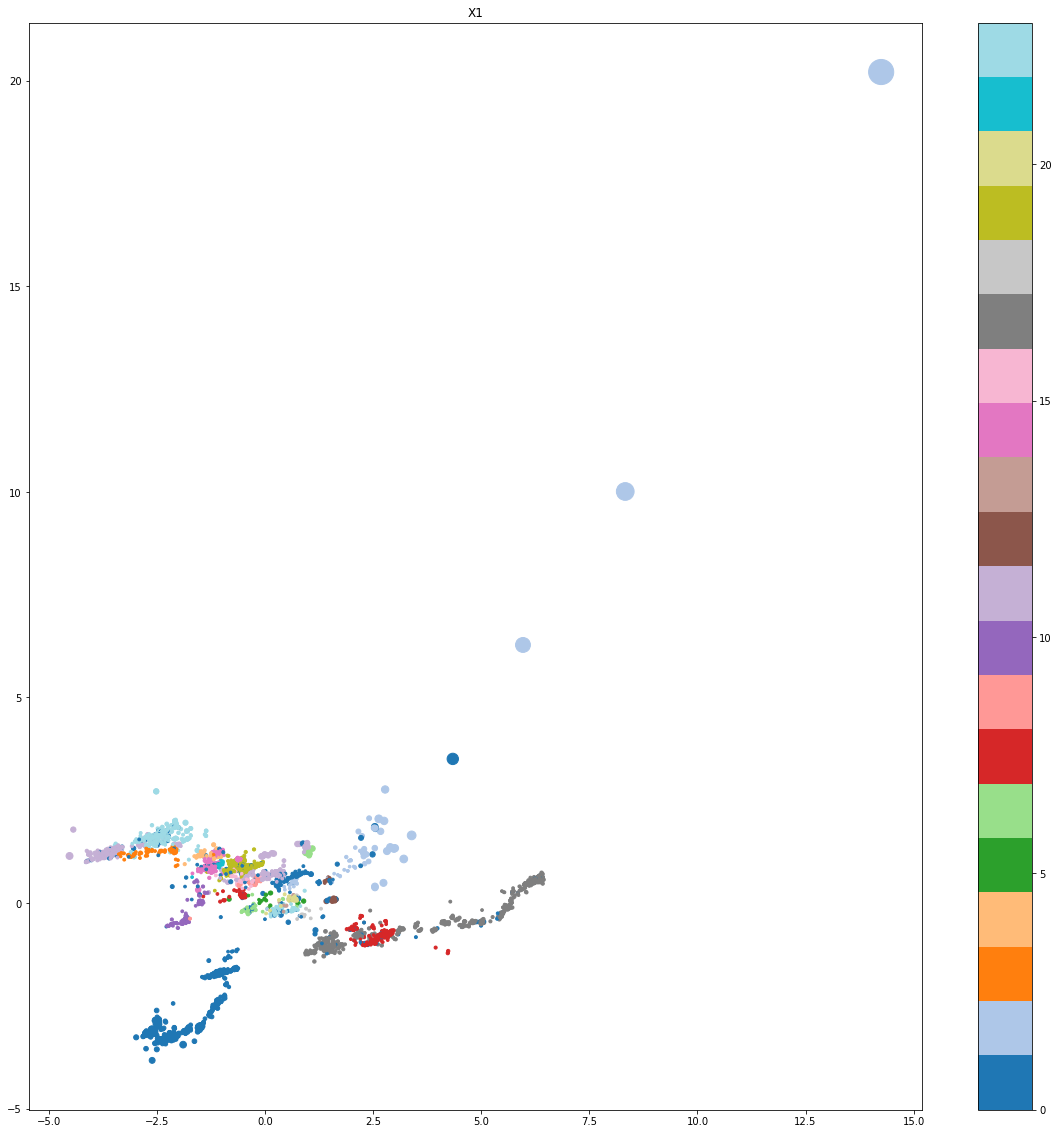

In [23]:
Xemv = Xe[mostvargenes,:]
reducer = PCA()
X1p_PCA = reducer.fit_transform(Xemv)
plt.figure(figsize=(20,20))
#plt.scatter(X1p_PCA[:,0],X1p_PCA[:,1],c='k',s=np.var(Xemv,axis=1)*100)
plt.scatter(X1p_PCA[:,0],X1p_PCA[:,1],c=chr_num_data[mostvargenes],s=np.var(Xemv,axis=1)*100,cmap='tab20')
plt.title('X1')
plt.colorbar()
plt.show()

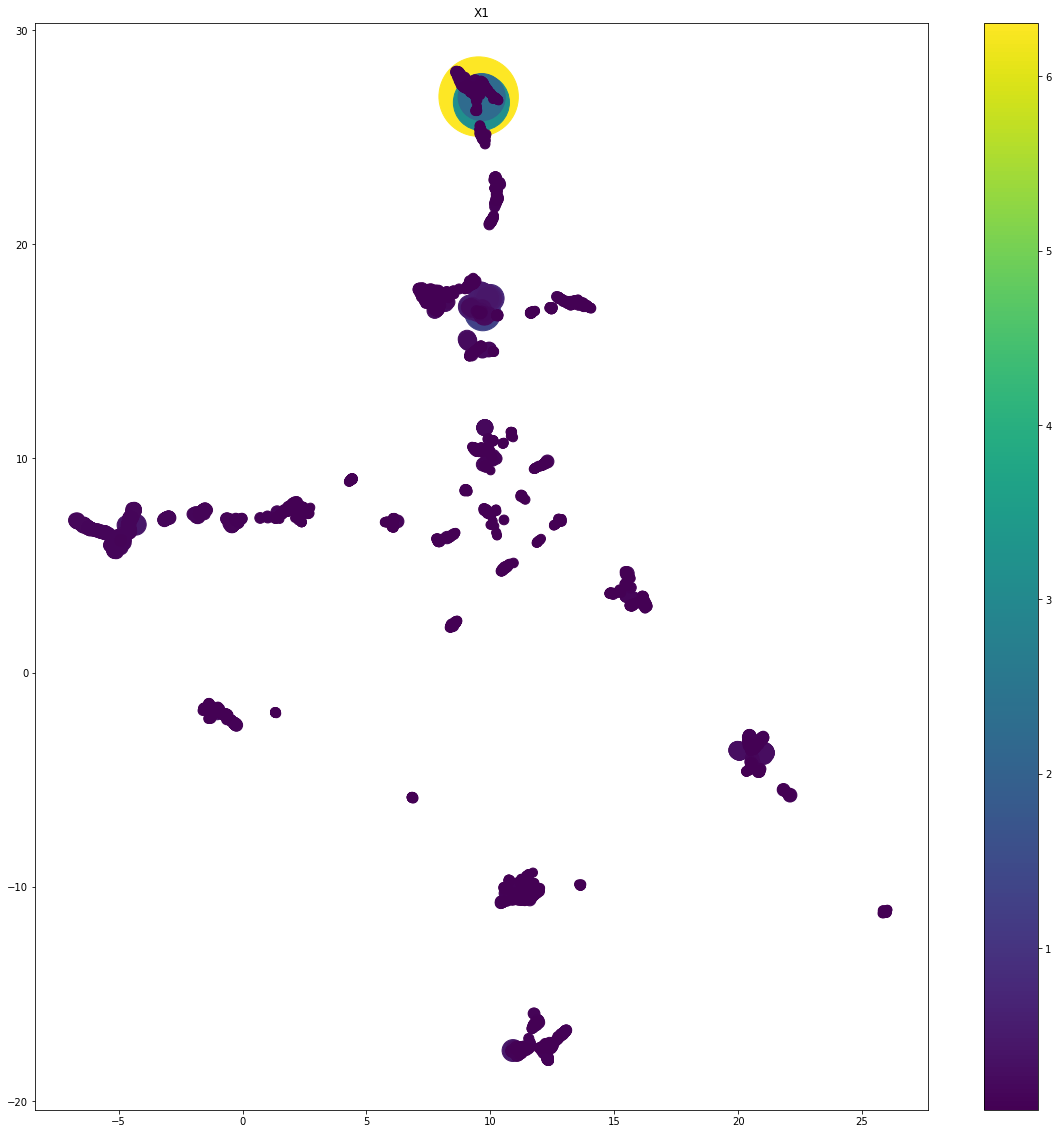

In [26]:
Xemv = Xe[mostvargenes,:]
metric = 'euclidean'
reducer = umap.UMAP(metric=metric,n_neighbors=500)
X1p_UMAP = reducer.fit_transform(Xemv)
plt.figure(figsize=(20,20))
plt.scatter(X1p_UMAP[:,0],X1p_UMAP[:,1],c=np.var(Xemv,axis=1),s=np.var(Xemv,axis=1)*1000)
plt.title('X1')
plt.colorbar()
plt.show()


(5000, 96)


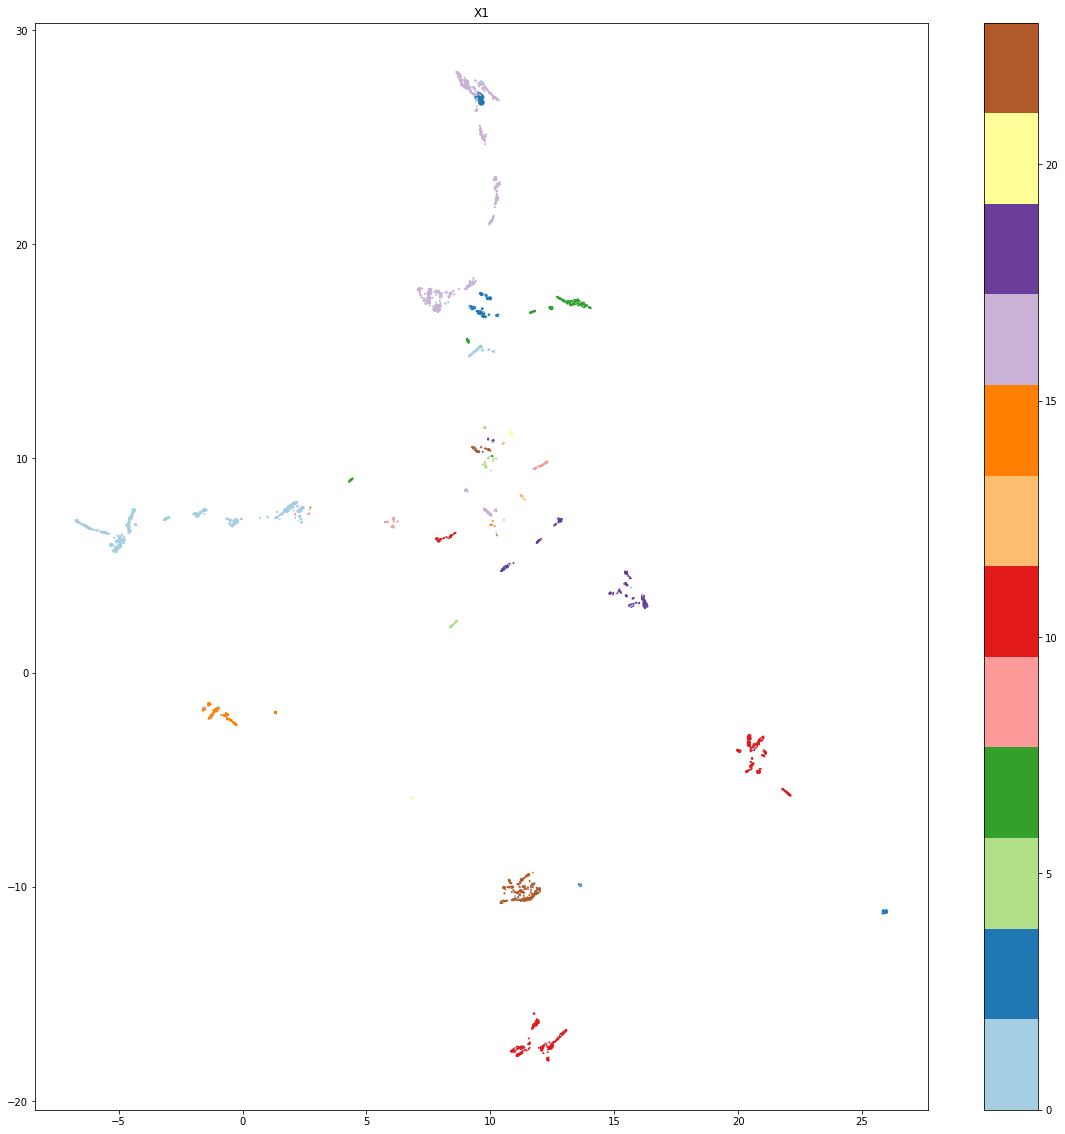

In [29]:
print(Xemv.shape)
plt.figure(figsize=(20,20))
plt.scatter(X1p_UMAP[:,0],X1p_UMAP[:,1],c=chr_num_data[mostvargenes],s=np.var(Xemv,axis=1)*10,cmap='Paired')
plt.title('X1')
plt.colorbar()
plt.show()


(5000,)


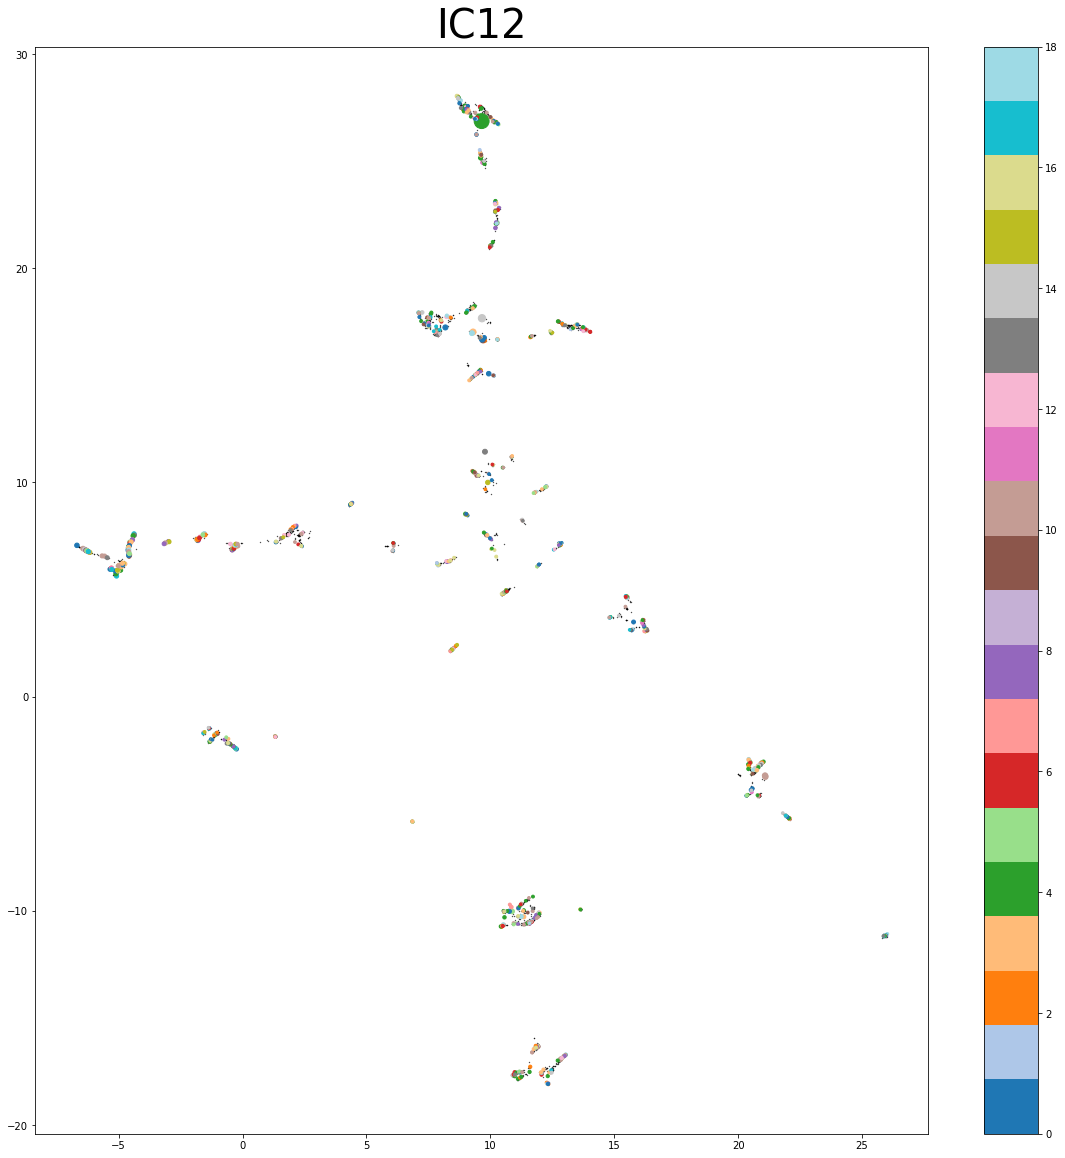

In [30]:
import scipy

plt.figure(figsize=(20,20))
col_var = scipy.stats.mstats.winsorize(np.var(Xemv,axis=1),limits=[0.05,0.05])
ic_num = 'IC12'
icX = df_ICA[ic_num].to_numpy()[mostvargenes]
Xp_ICA = df_ICA[df_ICA.columns[1:-1]].to_numpy()[mostvargenes]
Xp_ICA_ = Xp_ICA.flatten()
Xp_ICA_[Xp_ICA_<3] = 0
Xp_ICA = Xp_ICA_.reshape(Xp_ICA.shape[0],Xp_ICA.shape[1])
Xp_ICA_ = Xp_ICA_.reshape(Xp_ICA.shape[0],Xp_ICA.shape[1])
mns = np.mean(Xp_ICA,axis=1)
ics = np.argmax(Xp_ICA,axis=1)
ics[np.where(mns<1e-6)] = -1
col_ic = scipy.stats.mstats.winsorize(icX,limits=[0.05,0.05])
print(col_ic.shape)
#plt.scatter(X1p_UMAP[:,0],X1p_UMAP[:,1],c=col_ic,s=np.var(Xemv,axis=1)*100)
plt.scatter(X1p_UMAP[ics==-1,0],X1p_UMAP[ics==-1,1],c='k',s=0.1)
plt.scatter(X1p_UMAP[ics>-1,0],X1p_UMAP[ics>-1,1],c=ics[ics>-1],s=(np.var(Xemv,axis=1)*100)[ics>-1],cmap='tab20')
plt.title(ic_num,fontsize=40)
plt.colorbar()
plt.show()

if False:
    Xemv = Xe[mostvargenes,:]
    plt.figure(figsize=(20,20))
    #plt.scatter(X1p_PCA[:,0],X1p_PCA[:,1],c='k',s=np.var(Xemv,axis=1)*100)
    plt.scatter(X1p_PCA[:,0],X1p_PCA[:,1],c=ics,s=np.var(Xemv,axis=1)*300,cmap='tab20')
    plt.title('X1')
    plt.colorbar()
    plt.show()


In [237]:
print('y>25')
inds = np.where(X1p_UMAP[:,1]>25)[0]
print(len(genenames[mostvargenes][inds]))
print(genenames[mostvargenes][inds])
print('x>12')
inds = np.where(X1p_UMAP[:,0]>12)[0]
print(genenames[mostvargenes][inds])
print('y<-4')
inds = np.where(X1p_PCA[:,1]<-4)[0]
print(genenames[mostvargenes][inds])

y>25
0
[]
x>12
['NXPH1' 'LOC100132111' 'C2CD4D' 'CYP26C1' 'TBX1' 'NCAN' 'CHRNE'
 'C17orf107' 'TMEM171' 'TRABD' 'DERL3' 'ARL9' 'RTN4RL2' 'MMP23B' 'MMP23A'
 'COL23A1' 'CYP1B1' 'SCT' 'PRRT1' 'FERD3L' 'EBF1' 'CELSR3' 'PCDHGB7'
 'PCDHGB6' 'PCDHGB5' 'PCDHGB4' 'PCDHGB3' 'PCDHGB2' 'PCDHGA9' 'PCDHGB1'
 'PCDHGA7' 'PCDHGA6' 'PCDHGA5' 'PCDHGA4' 'PCDHGA3' 'PCDHGA12' 'PCDHGA11'
 'PCDHGA10' 'PCDHGA1' 'PCDHGA8' 'PCDHGA2' 'C21orf57' 'PRDM8' 'NTSR2'
 'DUSP23' 'ASPG' 'KLB' 'ANTXR2' 'DRD4' 'VAX2' 'LY75' 'UNC13A' 'MACROD1'
 'CMYA5' 'DLX5' 'ALPK3' 'NAPRT1' 'SLC26A10' 'FGF5' 'HHEX' 'CYBA' 'BAI1'
 'LOC100130148' 'MAPT' 'IZUMO1' 'RASIP1' 'TWIST1' 'CYR61' 'DDAH1' 'SPOCK2'
 'ELL3' 'ANKRD53' 'CFLAR' 'PCBP1' 'MIB2' 'TLX3' 'GCHFR' 'NKAIN1' 'PYCARD'
 'C21orf129' 'TAPBP' 'ZBTB22' 'MEGF8' 'KCNIP2' 'NEAT1' 'PPP1R13L' 'DPYS'
 'ACTN3' 'SH2D4A' 'ALOX12' 'FAM184B' 'STX1B' 'NEUROD1' 'TXNRD1' 'EVI5L'
 'PRLHR' 'C9orf167' 'ECHDC3' 'THSD1P' 'CHRNA4' 'ZMYND10' 'PCDH17' 'CACNG7'
 'KCNG3' 'VSTM2B' 'FBLN7' 'HCG4P6' 'BHMT2' 'DMGDH' 

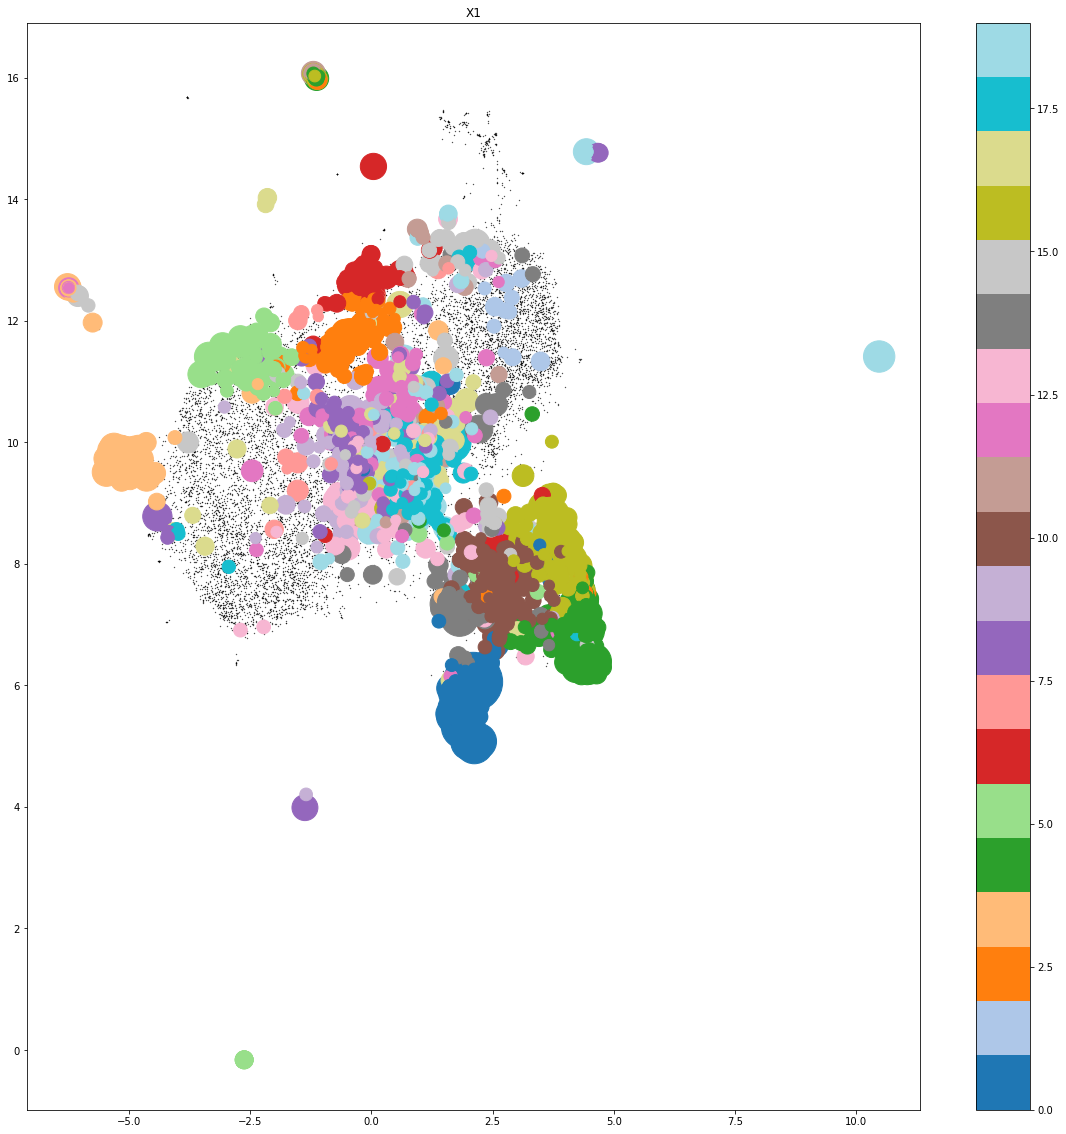

In [602]:
Xemv = Xe[mostvargenes,:]
metric = 'cosine'
reducer = umap.UMAP(metric=metric)
Xp_ICA_ = df_ICA[df_ICA.columns[1:-1]].to_numpy()[mostvargenes]
X1p_UMAP = reducer.fit_transform(Xp_ICA_)
plt.figure(figsize=(20,20))
plt.scatter(X1p_UMAP[ics==-1,0],X1p_UMAP[ics==-1,1],c='k',s=0.1)
plt.scatter(X1p_UMAP[ics>-1,0],X1p_UMAP[ics>-1,1],c=ics[ics>-1],s=(np.var(Xemv,axis=1)*300)[ics>-1],cmap='tab20')
plt.title('X1')
plt.colorbar()
plt.show()

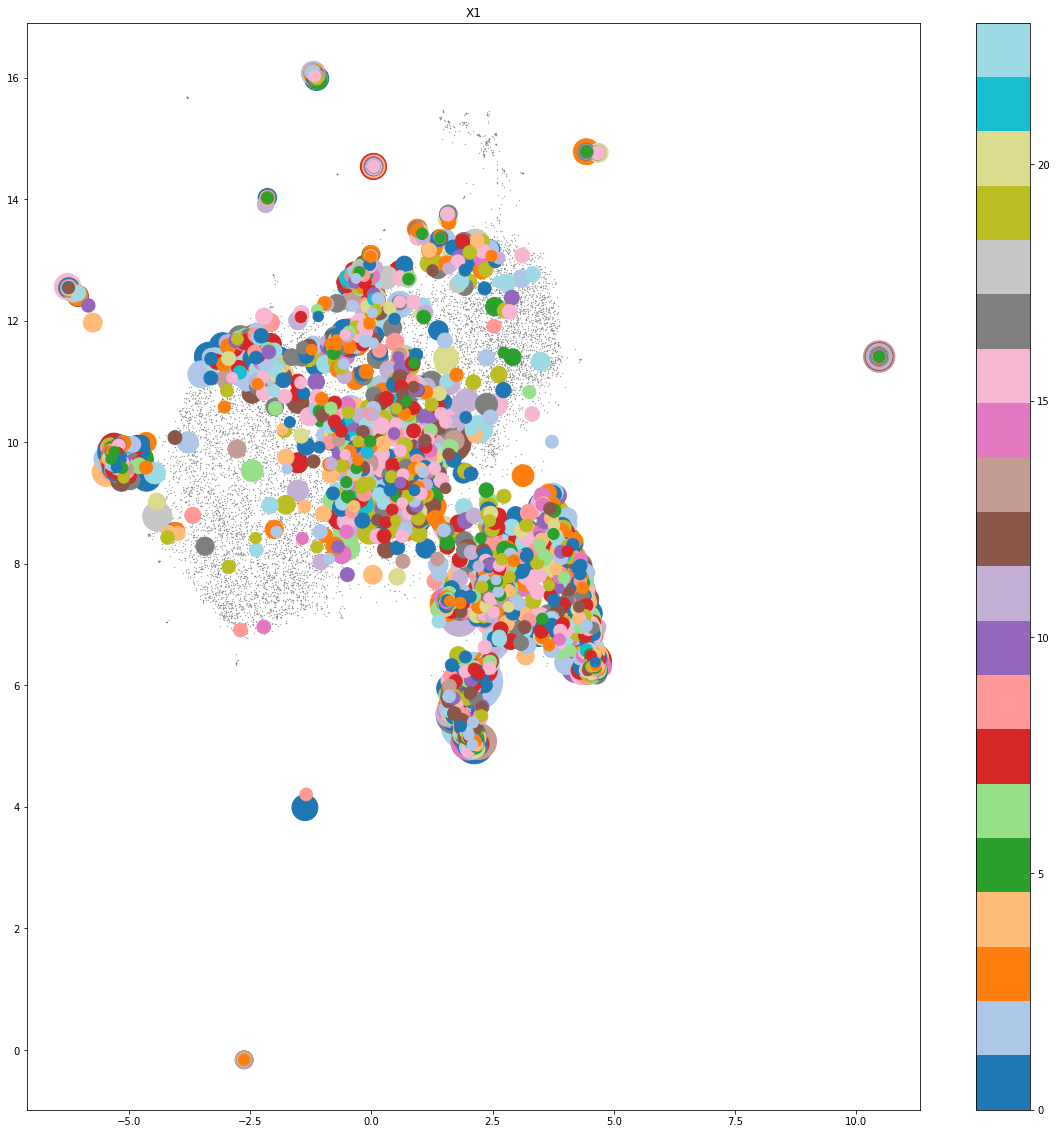

In [603]:
Xemv = Xe[mostvargenes,:]
metric = 'cosine'
plt.figure(figsize=(20,20))
plt.scatter(X1p_UMAP[ics==-1,0],X1p_UMAP[ics==-1,1],c='grey',s=0.1)
plt.scatter(X1p_UMAP[ics>-1,0],X1p_UMAP[ics>-1,1],c=chr_num_data[mostvargenes][ics>-1],s=(np.var(Xemv,axis=1)*300)[ics>-1],cmap='tab20')
plt.title('X1')
plt.colorbar()
plt.show()

In [35]:
print(irx)
print(Xp_ICA_complete.shape)
print(gene_pos_data.shape)

2
(21974, 19)
(17892,)


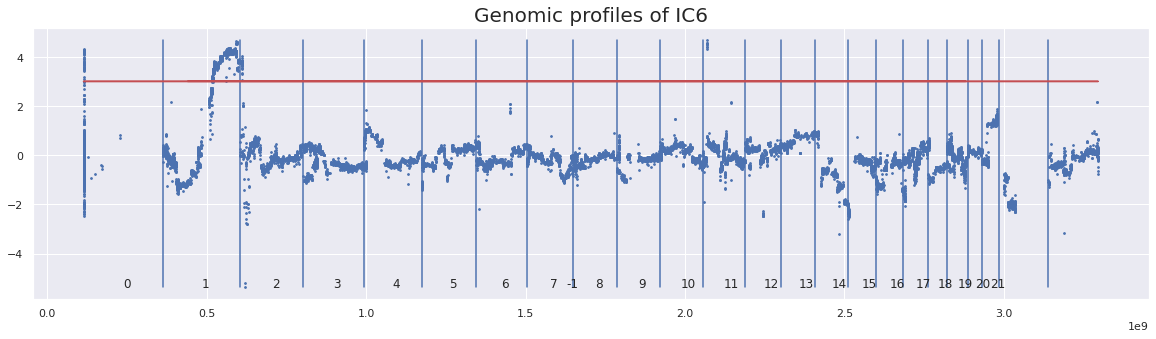

In [165]:
Xp_ICA_complete = df_ICA[df_ICA.columns[1:-1]].to_numpy()
plt.figure(figsize=[20,5])
irx = 6
plt.scatter(gene_pos_data,Xp_ICA_complete[:,irx-1],s=3)
#plt.scatter(gene_pos_data,df_ICA_exp['IC4'],s=3,c=df_ICA_exp['IC4'])
for i,c in enumerate(cs[1:]):
    plt.plot([c,c],[np.min(Xp_ICA_complete[:,irx-1]),np.max(Xp_ICA_complete[:,irx-1])],'b-')
    x_c = (cs[i]+cs[i-1])/2
    plt.text(x_c,np.min(Xp_ICA_complete[:,irx-1]),str(i-1))
#plt.xticks(np.unique(chr_num_data))
plt.plot(gene_pos_data,[3]*len(gene_pos_data),'r-')
plt.title(f'Genomic profiles of IC{irx}',fontsize=20)
plt.show()

16456


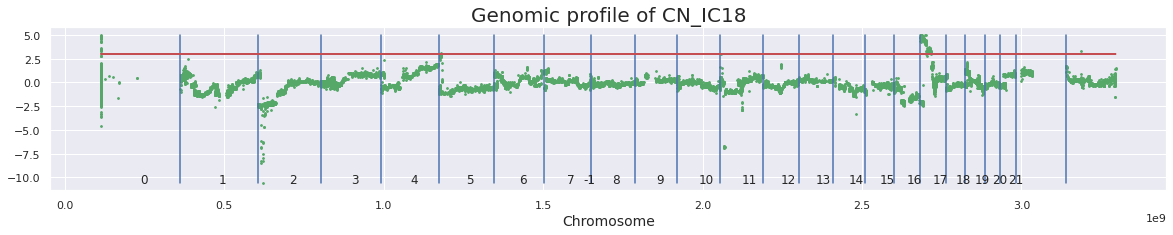

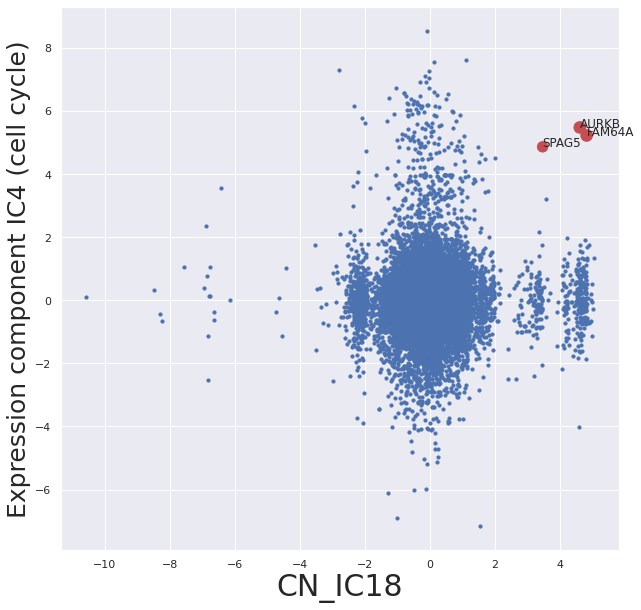

In [177]:
## Genomic profile,showing expression components

df_ICA_exp = pd.read_csv('/mnt/c/Users/zinovyev/Google Drive/iPC_CURIE/Neuroblastoma_multiomics/NB_multii_omics_amc/harmonized/data_analysis/ica_decompositions/NBAMC_expression_u133int_logx1_ica_S.xls',sep='\t')
df_ICA_exp = df_ICA_exp[df_ICA_exp.columns[:-1]]
#display(df_ICA_exp)
genenames_exp = df_ICA_exp['PROBE']
common_genes = list(set(genenames)&set(genenames_exp))
print(len(common_genes))
inds1 = ismember(common_genes,genenames)
inds_exp = ismember(common_genes,genenames_exp)

plt.figure(figsize=[20,3])
irx = 18
plt.scatter(gene_pos_data,Xp_ICA_complete[:,irx-1],s=3,c='g')
#plt.scatter(gene_pos_data[inds1],df_ICA_exp['IC4'][inds_exp],s=3,c=df_ICA_exp['IC4'][inds_exp])
for i,c in enumerate(cs[1:]):
    plt.plot([c,c],[np.min(Xp_ICA_complete[:,irx-1]),np.max(Xp_ICA_complete[:,irx-1])],'b-')
    x_c = (cs[i]+cs[i-1])/2
    plt.text(x_c,np.min(Xp_ICA_complete[:,irx-1]),str(i-1))
#plt.xticks(np.unique(chr_num_data))
plt.plot(gene_pos_data,[3]*len(gene_pos_data),'r-')
plt.title(f'Genomic profile of CN_IC{irx}',fontsize=20)
plt.xlabel('Chromosome',fontsize=14)
plt.show()

x1 = Xp_ICA_complete[inds1,irx-1]
y1 = df_ICA_exp['IC4'][inds_exp].to_numpy()
sm = x1*1.7+y1
sind = np.argsort(-sm)

num_gene = 3
plt.figure(figsize=[10,10])
plt.scatter(x1,y1,s=10)
plt.scatter(x1[sind[0:num_gene]],y1[sind[0:num_gene]],c='r',s=sm[sind[0:num_gene]]*10)
plt.xlabel(f'CN_IC{irx}',fontsize=30)
plt.ylabel('Expression component IC4 (cell cycle)',fontsize=25)
for s in range(num_gene):
    plt.text(x1[sind[s]],y1[sind[s]],genenames[inds1][sind[s]])
plt.show()

In [490]:
# Compute gene network correlations based on ICA profiles and on an PPI network


cr = np.corrcoef(Xemv)
print('Correlations computed')
cr[cr>1-1e-10] = 0
#plt.hist(cr.flatten(),bins=100)
plt.show()
thresh = 0.7
inds = np.nonzero(cr>0.5)
print(len(inds[0]),' correlations computed. thresh=',thresh)
with open(folder+'NBAMC_corrgraph.txt','w') as f:
    f.write('GENE1\tGENE2\tCORR\n')
    for i in range(len(inds[0])):
        k = inds[0][i]
        l = inds[1][i]
        if k>l:
            f.write(genenames[mostvargenes][k]+'\t'+genenames[mostvargenes][l]+'\t'+str(cr[k,l])+'\n')

Correlations computed


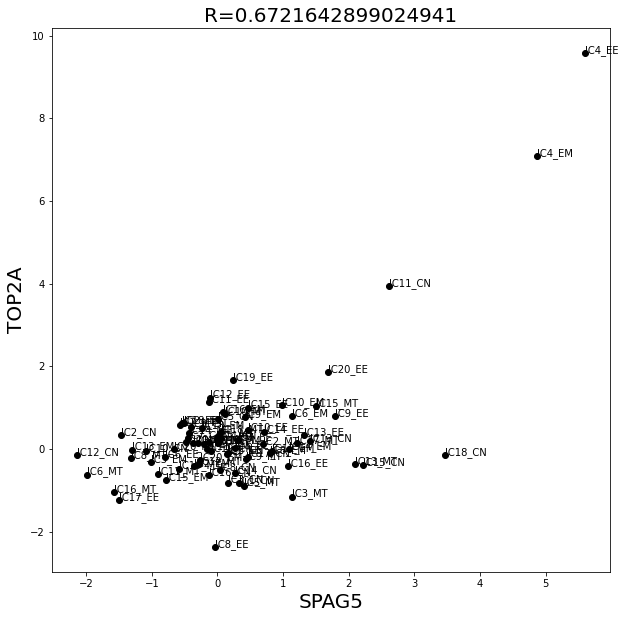

IC4_EE 0.4800440414562074
IC4_EM 0.3029896442472526


In [157]:
#gene1 = 'DDX1'
#gene2 = 'MYCN'
#gene1 = 'NASP'
#gene2 = 'SFPQ'
#gene1 = 'SPAG5'
#gene2 = 'AURKB'
gene1 = 'SPAG5'
gene2 = 'TOP2A'

X = X.astype(float)

i1 = np.where(np.array(genenames)==gene1)[0][0]
i2 = np.where(np.array(genenames)==gene2)[0][0]
plt.figure(figsize=(10,10))
plt.plot(X[i1,:],X[i2,:],'ko')
for k,t in enumerate(samplenames):
    plt.text(X[i1,k],X[i2,k],t)
plt.xlabel(gene1,fontsize=20)
plt.ylabel(gene2,fontsize=20)
plt.title(f'R={np.corrcoef(X[i1,:].astype(float),X[i2,:].astype(float))[0,1]}',fontsize=20)
plt.show()



mn1 = np.mean(X[i1,:])
std1 = np.std(X[i1,:])
mn2 = np.mean(X[i2,:])
std2 = np.std(X[i2,:])
ic_scores=[]
for k in range(X.shape[1]):
    ic_scores.append((X[i1,k]-mn1)*(X[i2,k]-mn2)/(std1*std2))
ic_scores = np.array(ic_scores)/np.sum(np.array(ic_scores))
#print(ic_scores.shape)
#inds = np.argsort(-np.array(ic_scores))
thresh = 0.1
for i in range(ic_scores.shape[0]):
    if ic_scores[i]>thresh:
        print(samplenames[i],ic_scores[i])

In [ ]:
dfMI = pd.read_csv(folder_analysis+'ica_decompositions/NBAMC_multiICA.txt',sep='\t')
X = dfMI[:].to_numpy()[:,1:]
genenames = list(dfMI['GENE'])
samplenames = dfMI.columns[1:]
print(samplenames)
print(X.shape)
print(len(genenames))

In [171]:
corr_df = pd.read_csv(folder_analysis+'ica_decompositions/NBAMC_corrgraph.txt',sep='\t')
display(corr_df)
A = np.zeros((len(genenames),len(genenames))).astype(np.float)
print(A.shape)
name2ind = {}
for i,g in enumerate(genenames):
    name2ind[g] = i
for r in corr_df.iterrows():
    gene1 = r[1]['GENE1']
    gene2 = r[1]['GENE2']
    corr = r[1]['CORR']
    if corr>=0.65:
        i1 = name2ind[gene1]
        i2 = name2ind[gene2]
        A[i1,i2] = 1
        A[i2,i1] = 1
A = sparse.csr_matrix(A)

,GENE1,GENE2,CORR
0,DDX1,MYCN,0.689259
1,USP9X,XG,0.943092
2,DDX3X,XG,0.963763
3,DDX3X,USP9X,0.963557
4,ASCL1,DLK1,0.590250
...,...,...,...
355380,MFAP3,FAM13B,0.611888
355381,MFAP3,FBXW11,0.644017
355382,MFAP3,MIER3,0.677325
355383,MFAP3,RAD17,0.786464


/home/zinovyev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


(15115, 15115)


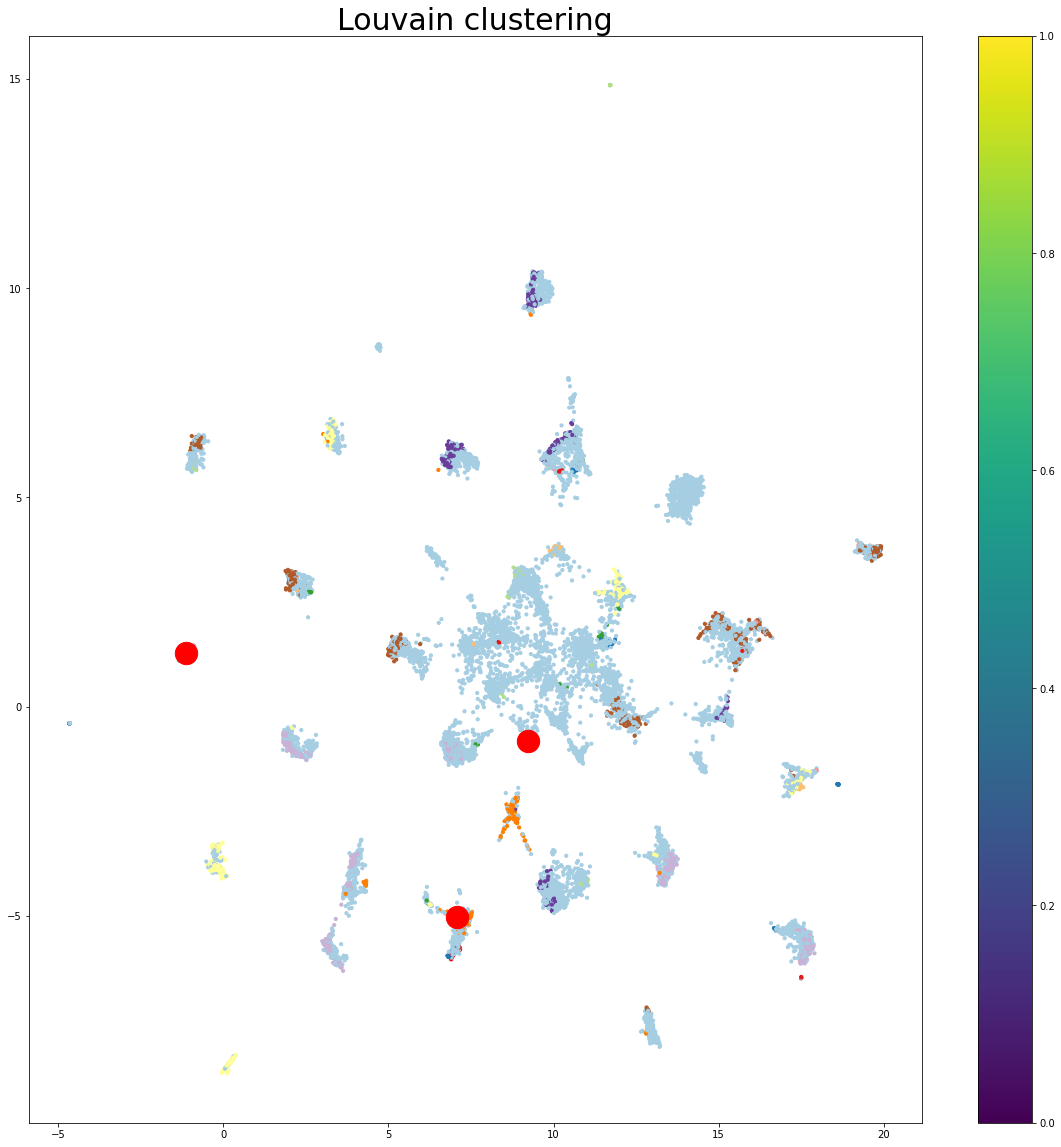

In [849]:
from sknetwork.clustering import Louvain
from sklearn.neighbors import kneighbors_graph

metric = 'cosine'
reducer = umap.UMAP(metric=metric)
X1p_UMAP = reducer.fit_transform(X)

#A1 = kneighbors_graph(X, 20, mode='connectivity', include_self=False,metric='cosine')
#louvain = Louvain(resolution=1)
#labels = louvain.fit_transform(A)
#print('Number of clusters = ',len(np.unique(labels)))

plt.figure(figsize=(20,20))
#plt.scatter(X1p_UMAP[:,0],X1p_UMAP[:,1],c=labels,s=10,cmap='Paired')
#plt.scatter(X1p_UMAP[:,0],X1p_UMAP[:,1],c=cluster_inds,s=10,cmap='Paired')
plt.scatter(X1p_UMAP[:,0],X1p_UMAP[:,1],c=comp_inds2,s=10,cmap='Paired')
plt.scatter(X1p_UMAP[genenames.index('MYNN'),0],X1p_UMAP[genenames.index('MYNN'),1],c='r',s=500)
plt.scatter(X1p_UMAP[genenames.index('AARSD1'),0],X1p_UMAP[genenames.index('AARSD1'),1],c='r',s=500)
plt.scatter(X1p_UMAP[genenames.index('MYO5B'),0],X1p_UMAP[genenames.index('MYO5B'),1],c='r',s=500)

rows,cols = A.nonzero()
#for row,col in zip(rows,cols):
#    if row>col:
#        plt.plot([X1p_UMAP[row,0],X1p_UMAP[col,0]],[X1p_UMAP[row,1],X1p_UMAP[col,1]],'k-',alpha=0.1)
plt.title('Louvain clustering',fontsize=30)
plt.colorbar()
plt.show()

In [172]:
import markov_clustering as mc
import networkx as nx
import random

G = nx.from_scipy_sparse_matrix(A)
deg = nx.degree(G)
print(nx.info(G))
irx = []
for d in deg:
    if d[1]>0:
        irx.append(d[0])
print(len(irx))
A1 = A[irx,:][:,irx]
G1 = nx.from_scipy_sparse_matrix(A1)
print(nx.info(G1))

Name: 
Type: Graph
Number of nodes: 15115
Number of edges: 53500
Average degree:   7.0791
9127
Name: 
Type: Graph
Number of nodes: 9127
Number of edges: 53500
Average degree:  11.7235


In [180]:
pos = nx.spring_layout(G1,iterations=30,threshold=0.0001)

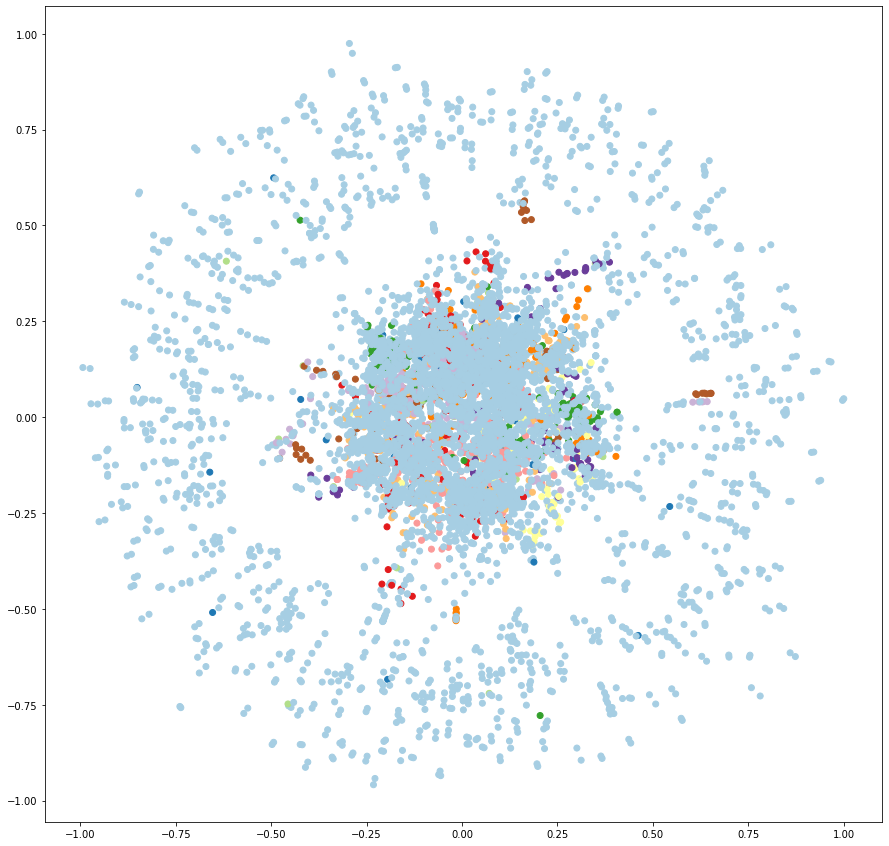

In [181]:
posp = np.zeros((len(irx),2))
for p in pos:
    posp[p,:] = pos[p]
plt.figure(figsize=(15,15))
plt.scatter(posp[:,0],posp[:,1],c=comp_inds2[irx],cmap='Paired')
#plt.scatter(posp[:,0],posp[:,1],c='r',cmap='Paired')
rows,cols = A1.nonzero()
if False:
    for row,col in zip(rows,cols):
        if row>col:
            plt.plot([posp[row,0],posp[col,0]],[posp[row,1],posp[col,1]],'k-',alpha=0.1)

plt.show()

In [240]:
## Extracting the signatures from the multiomics correlation graph

mx = np.max(X,axis=1)
thresh = 3.0
colored = np.zeros(len(genenames))
for i in range(X.shape[0]):
    if mx[i]>thresh:
        colored[i] = 1

comps = nx.connected_components(G1)
comps_dic = {}
for k,c in enumerate(comps):
    comps_dic[k] = list(c)
comp_inds = np.zeros(A.shape[0])
comp_inds1 = np.zeros(A.shape[0])
comp_inds2 = np.zeros(A.shape[0])
comp_sizes = []
comp_sizes_colored = []
comps = nx.connected_components(G1)
genenames1 = np.array(genenames)[irx]
for k,c in enumerate(comps):
    count_colored = 0
    for i in c:
        comp_inds[i] = k
        if colored[i]:
            count_colored+=1
    comp_sizes.append(len(c))
    comp_sizes_colored.append(count_colored)
    
comp_sizes = np.array(comp_sizes)
comp_sizes_colored = np.array(comp_sizes_colored)
inds_sizes = np.argsort(-comp_sizes_colored)

components = []
components_to_cluster = []
for i in inds_sizes:
    if comp_sizes_colored[i]<5:
        break
    if comp_sizes[i]>100:
        components_to_cluster.append(comps_dic[i])
    else:
        components.append(comps_dic[i])
        #comp_inds2[comps_dic[i]] = i+1
                
print('Number of components:',len(components))
print('Number of components for clustering:',len(components_to_cluster))

for c in components_to_cluster:
    print('Component to cluster with',len(c),'nodes...')
    Atemp = A[np.array(irx)[c],:][:,np.array(irx)[c]].copy()
    print('Running MCL algorithm...')
    result = mc.run_mcl(Atemp,expansion=10)           
    clusters = mc.get_clusters(result)
    print('Number of clusters',len(clusters))
    for i,cl in enumerate(clusters):
        #print(cl)
        count_colored = 0
        for ii in cl:
            if colored[irx][c[ii]]:
                count_colored+=1
        if count_colored>=5:
            #comp_inds2[np.array(c)[list(cl)]] = i+1
            components.append(list(np.array(c)[list(cl)]))
                        
print('Total number of components:',len(components))
for i,comp in enumerate(components):
    comp_inds2[np.array(irx)[comp]] = i+1
    
comp10 = components[10]
comp10 = np.where(comp_inds2==11)[0]
print(np.array(genenames)[comp10])

    
print('Naming components by central genes...')

component_names = []
for i,comp in enumerate(components):
    Ai = A1[comp,:][:,comp].copy()
    Gi = nx.from_scipy_sparse_matrix(Ai)
    dg = np.array(nx.degree(Gi))
    dg = [d[1] for d in dg]
    i1 = np.argmax(dg)
    component_names.append('CL_'+genenames1[comp[i1]])
    
with open(folder_analysis+'ica_decompositions/NBAMC_corrgraph_components.txt','w') as f:
    for i,comp in enumerate(components):
        gns = np.array(genenames1)[comp]
        num_col = 0
        for c in comp:
            num_col+=colored[irx][c]
        f.write(component_names[i]+'\t'+str(len(gns))+'\t'+str(int(num_col))+'\t['+','.join(gns)+']\n')



Number of components: 28
Number of components for clustering: 2
Component to cluster with 7225 nodes...
Running MCL algorithm...
Number of clusters 81
Component to cluster with 137 nodes...
Running MCL algorithm...
Number of clusters 4
Total number of components: 93
['GAGE1' 'GAGE12B' 'GAGE12C' 'GAGE12D' 'GAGE12E' 'GAGE12F' 'GAGE12G'
 'GAGE12I' 'GAGE4' 'GAGE5' 'GAGE6' 'GAGE7']
Naming components by central genes...


15115


In [241]:
mx = np.max(X,axis=1)
thresh = 3.0
labels = comp_inds2.astype(np.int)
colored = np.zeros(len(genenames))
comps_associated = []
with open(folder_analysis+'ica_decompositions/NBAMC_corrgraph_ann.txt','w') as f:
    f.write('GENE\tCLASS\tCOMPS\tCLUSTER\tCLUSTER_NAME\tCHR\tPOS\n')
    for i in range(X.shape[0]):
        gn = genenames[i]
        kk = np.where(np.array(gns_prop)==gn)[0]
        kkk = np.array(chr_num).astype(int)[kk]>0
        #print(gn,kkk,kk)
        if (len(kkk)==1)&(not kkk[0]):
            kk = kk[0]
        else:
            kk = kk[kkk][0]
        chr_number = chr_num[kk]
        gpos = int(chr_number)+gene_start_millions[kk]/100
        component_name = '_'
        if labels[i]>0:
            component_name = component_names[labels[i]-1]
        
        if mx[i]>thresh:
            inds = np.argsort(-X[i,:])
            inds = inds[X[i,inds]>thresh]
            comps = samplenames[inds]
            inds = (inds/20).astype(np.int)
            lab = ''
            if (1 in inds) or (2 in inds):
                lab+='E'
            if 0 in inds:
                lab+='C'
            if 3 in inds:
                lab+='M'
            print(gn,inds,lab,','.join(comps))
            comps_associated.append(comps)
            f.write(gn+'\t'+lab+'\t'+','.join(comps)+'\t'+str(labels[i])+'\t'+component_name+'\t'+str(chr_number)+'\t'+'{:2.2f}'.format(gpos)+'\n')
            colored[i]
        else:
            f.write(gn+'\t_\t_\t'+str(labels[i])+'\t'+component_name+'\t'+str(chr_number)+'\t'+'{:2.2f}'.format(gpos)+'\n')
            comps_associated.append([])
            

/home/zinovyev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/home/zinovyev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. I

A1BG [2 0] EC IC1_EM,IC4_CN
A1CF [1 2 0 3] ECM IC1_EE,IC1_EM,IC8_CN,IC9_MT
A2M [1 1] E IC7_EE,IC1_EE
AACS [0] C IC20_CN
AADAC [1 2] E IC1_EE,IC1_EM
AAGAB [0] C IC10_CN
AAK1 [3] M IC13_MT
AANAT [0 3] CM IC11_CN,IC2_MT
AARS [3] M IC18_MT
AARS2 [0] C IC7_CN
AARSD1 [0] C IC11_CN
AASDH [2] E IC7_EM
AASDHPPT [0] C IC15_CN
AASS [0 3 1] ECM IC9_CN,IC16_MT,IC8_EE
AATF [0] C IC11_CN
ABAT [2] E IC19_EM
ABCA1 [0] C IC1_CN
ABCA12 [1 1 1 1 1] E IC18_EE,IC17_EE,IC19_EE,IC13_EE,IC7_EE
ABCA13 [3 0] CM IC16_MT,IC9_CN
ABCA2 [0] C IC1_CN
ABCA4 [3] M IC3_MT
ABCA5 [0 1 1] EC IC11_CN,IC12_EE,IC19_EE
ABCA6 [1 0 3 1 3] ECM IC8_EE,IC11_CN,IC16_MT,IC1_EE,IC13_MT
ABCA8 [1 2 2 3 0 3] ECM IC8_EE,IC15_EM,IC11_EM,IC16_MT,IC11_CN,IC13_MT
ABCA9 [1 0 3 2 1] ECM IC8_EE,IC11_CN,IC16_MT,IC15_EM,IC7_EE
ABCB1 [1 1 2 2 3 1 0 2] ECM IC15_EE,IC14_EE,IC20_EM,IC18_EM,IC11_MT,IC13_EE,IC9_CN,IC10_EM
ABCB10 [0] C IC6_CN
ABCB11 [1 2] E IC1_EE,IC1_EM
ABCB4 [2 2 1 0 2] EC IC20_EM,IC18_EM,IC1_EE,IC9_CN,IC10_EM
ABCB5 [3] M IC16_MT
ABCB7 

AKAP12 [3 3 0 3] CM IC18_MT,IC5_MT,IC7_CN,IC12_MT
AKAP13 [0 3 3] CM IC10_CN,IC7_MT,IC3_MT
AKAP14 [0] C IC3_CN
AKAP2 [0] C IC1_CN
AKAP4 [0] C IC3_CN
AKAP5 [0] C IC19_CN
AKAP6 [1] E IC12_EE
AKAP7 [1 3 0] ECM IC13_EE,IC2_MT,IC7_CN
AKAP9 [0] C IC9_CN
AKIRIN2 [0] C IC7_CN
AKNA [0 2 3] ECM IC1_CN,IC5_EM,IC3_MT
AKR1B1 [0] C IC9_CN
AKR1B10 [0] C IC9_CN
AKR1C1 [0] C IC8_CN
AKR1C2 [0] C IC8_CN
AKR1C3 [2 0 3] ECM IC1_EM,IC8_CN,IC16_MT
AKR1C4 [0 2] EC IC8_CN,IC1_EM
AKR1D1 [2 0] EC IC1_EM,IC9_CN
AKR1E2 [0] C IC8_CN
AKR7A2 [0] C IC13_CN
AKR7A3 [0 3] CM IC13_CN,IC8_MT
AKT1 [0] C IC19_CN
AKT1S1 [2 0] EC IC3_EM,IC4_CN
AKT3 [0 1] EC IC6_CN,IC11_EE
ALAD [0] C IC1_CN
ALAS1 [0] C IC5_CN
ALAS2 [0 1] EC IC3_CN,IC9_EE
ALB [1 2 3] EM IC1_EE,IC1_EM,IC9_MT
ALCAM [1 2] E IC15_EE,IC9_EM
ALDH16A1 [0] C IC4_CN
ALDH18A1 [0 1] EC IC8_CN,IC17_EE
ALDH1A1 [1 0 3 1 2 2] ECM IC8_EE,IC1_CN,IC16_MT,IC1_EE,IC11_EM,IC1_EM
ALDH1A2 [2 2 0] EC IC13_EM,IC16_EM,IC10_CN
ALDH1A3 [0 2 2] EC IC10_CN,IC11_EM,IC17_EM
ALDH1B1 [0 2] EC IC1

ARMC3 [0 3] CM IC8_CN,IC20_MT
ARMC4 [0] C IC8_CN
ARMC7 [0] C IC11_CN
ARMCX1 [0] C IC3_CN
ARMCX2 [0] C IC3_CN
ARMCX3 [0] C IC3_CN
ARMCX5 [0] C IC3_CN
ARMCX6 [0] C IC3_CN
ARNT2 [0] C IC10_CN
ARNTL [0 0] C IC6_CN,IC12_CN
ARPC1A [0] C IC9_CN
ARPC1B [3 0] CM IC2_MT,IC9_CN
ARPC4 [0] C IC5_CN
ARPC5 [0] C IC6_CN
ARPC5L [0] C IC1_CN
ARPP19 [0] C IC10_CN
ARR3 [0] C IC3_CN
ARRB1 [0 3] CM IC15_CN,IC11_MT
ARRB2 [0] C IC18_CN
ARRDC1 [0] C IC1_CN
ARRDC2 [3] M IC6_MT
ARRDC4 [0] C IC10_CN
ARSD [0] C IC3_CN
ARSE [0] C IC3_CN
ARSF [0] C IC3_CN
ARSG [0 1] EC IC11_CN,IC7_EE
ARSJ [3] M IC16_MT
ARSK [2] E IC7_EM
ART1 [0] C IC12_CN
ART3 [2 1 1 1] E IC15_EM,IC10_EE,IC3_EE,IC7_EE
ART4 [2 0] EC IC5_EM,IC20_CN
ART5 [0] C IC12_CN
ARV1 [0] C IC6_CN
ARX [2 2 0 3 2 3 2] ECM IC12_EM,IC14_EM,IC3_CN,IC18_MT,IC16_EM,IC13_MT,IC8_EM
AS3MT [0] C IC8_CN
ASAH1 [0] C IC2_CN
ASAH2B [0] C IC8_CN
ASAP1 [3 0] CM IC18_MT,IC2_CN
ASAP2 [3] M IC11_MT
ASAP3 [0 2] EC IC13_CN,IC10_EM
ASB1 [3] M IC18_MT
ASB10 [0] C IC9_CN
ASB11 [0] C IC3_

BLVRB [2] E IC17_EM
BLZF1 [0] C IC6_CN
BMF [0] C IC10_CN
BMI1 [0 1] EC IC8_CN,IC12_EE
BMP1 [0] C IC2_CN
BMP15 [0] C IC3_CN
BMP2 [0 3] CM IC17_CN,IC14_MT
BMP4 [0] C IC19_CN
BMP5 [0 2 3] ECM IC7_CN,IC15_EM,IC13_MT
BMP6 [0 3] CM IC7_CN,IC6_MT
BMP7 [2 1 2 0 2 2 1] EC IC13_EM,IC18_EE,IC14_EM,IC17_CN,IC20_EM,IC9_EM,IC14_EE
BMPER [3] M IC20_MT
BMPR1A [0] C IC8_CN
BMPR1B [2 1] E IC9_EM,IC9_EE
BMS1 [0] C IC8_CN
BMX [0 2] EC IC3_CN,IC5_EM
BNC1 [0 3 3] CM IC10_CN,IC14_MT,IC16_MT
BNC2 [1 2 0 1 1 1] EC IC14_EE,IC19_EM,IC1_CN,IC7_EE,IC8_EE,IC20_EE
BNIP2 [0] C IC10_CN
BNIP3L [0] C IC2_CN
BOC [3] M IC15_MT
BOLA1 [3] M IC17_MT
BPGM [0] C IC9_CN
BPHL [0] C IC7_CN
BPI [0] C IC17_CN
BPNT1 [0] C IC6_CN
BPTF [0 2] EC IC11_CN,IC7_EM
BRAF [0 3] CM IC9_CN,IC11_MT
BRAP [0] C IC20_CN
BRCA1 [1 2 0 3 1] ECM IC4_EE,IC4_EM,IC11_CN,IC20_MT,IC19_EE
BRCA2 [1 2 2] E IC4_EE,IC4_EM,IC3_EM
BRCC3 [3 0] CM IC1_MT,IC3_CN
BRD2 [0] C IC7_CN
BRD3 [0] C IC1_CN
BRD4 [2] E IC6_EM
BRD8 [1] E IC4_EE
BRD9 [1 3] EM IC4_EE,IC10_MT
BRDT 

C9orf114 [0] C IC1_CN
C9orf116 [0 3] CM IC1_CN,IC6_MT
C9orf131 [0] C IC1_CN
C9orf142 [0 3] CM IC1_CN,IC17_MT
C9orf16 [0] C IC1_CN
C9orf163 [0] C IC1_CN
C9orf172 [0 0] C IC1_CN,IC16_CN
C9orf24 [0 3] CM IC1_CN,IC8_MT
C9orf3 [0] C IC1_CN
C9orf40 [0] C IC1_CN
C9orf47 [0] C IC1_CN
C9orf64 [0] C IC1_CN
C9orf66 [0] C IC1_CN
C9orf72 [0] C IC1_CN
C9orf78 [0] C IC1_CN
C9orf84 [0] C IC1_CN
C9orf85 [0] C IC1_CN
C9orf9 [0] C IC1_CN
C9orf91 [0] C IC1_CN
CA1 [2 0 1 1 1] EC IC17_EM,IC2_CN,IC9_EE,IC15_EE,IC7_EE
CA10 [0 2] EC IC11_CN,IC10_EM
CA11 [0] C IC4_CN
CA12 [0] C IC10_CN
CA13 [0] C IC2_CN
CA2 [0 2] EC IC2_CN,IC17_EM
CA3 [0] C IC2_CN
CA4 [0] C IC11_CN
CA5A [2 3] EM IC1_EM,IC11_MT
CA5B [0 2] EC IC3_CN,IC3_EM
CA6 [0] C IC13_CN
CA8 [0 3] CM IC2_CN,IC15_MT
CA9 [0] C IC1_CN
CAB39L [1 2 2] E IC8_EE,IC3_EM,IC15_EM
CABLES1 [0] C IC14_CN
CABP1 [0] C IC20_CN
CABP2 [0] C IC12_CN
CABP4 [0] C IC12_CN
CABP5 [0 3] CM IC4_CN,IC9_MT
CABYR [0] C IC14_CN
CACNA1A [3] M IC6_MT
CACNA1B [0 2] EC IC1_CN,IC9_EM
CACNA1C [3

CD109 [1 3 0] ECM IC7_EE,IC16_MT,IC7_CN
CD14 [1 2 3] EM IC7_EE,IC17_EM,IC8_MT
CD151 [3 0] CM IC18_MT,IC12_CN
CD163 [1 2 1 2] E IC7_EE,IC11_EM,IC10_EE,IC17_EM
CD163L1 [3 2] EM IC16_MT,IC17_EM
CD177 [3 0 1 1] ECM IC2_MT,IC4_CN,IC14_EE,IC18_EE
CD180 [1 2] E IC3_EE,IC5_EM
CD19 [2 3] EM IC5_EM,IC4_MT
CD1A [0] C IC6_CN
CD1B [0] C IC6_CN
CD1C [2 0 1] EC IC5_EM,IC6_CN,IC3_EE
CD1D [0] C IC6_CN
CD1E [2 2 0 1] EC IC5_EM,IC18_EM,IC6_CN,IC3_EE
CD2 [1 2] E IC3_EE,IC5_EM
CD200R1 [1] E IC3_EE
CD22 [1 2 3] EM IC3_EE,IC5_EM,IC6_MT
CD226 [0 1] EC IC14_CN,IC3_EE
CD244 [3 0] CM IC9_MT,IC6_CN
CD247 [2 1 0] EC IC5_EM,IC3_EE,IC6_CN
CD248 [0] C IC12_CN
CD27 [1 2] E IC3_EE,IC5_EM
CD274 [0] C IC1_CN
CD276 [0] C IC10_CN
CD28 [1 2] E IC3_EE,IC5_EM
CD2AP [0] C IC7_CN
CD300A [0 2 3 3] ECM IC11_CN,IC17_EM,IC14_MT,IC4_MT
CD300C [0 3] CM IC11_CN,IC4_MT
CD300LB [0 3] CM IC11_CN,IC4_MT
CD300LF [0 2] EC IC11_CN,IC17_EM
CD300LG [0] C IC11_CN
CD302 [2 3] EM IC11_EM,IC11_MT
CD33 [0 2] EC IC4_CN,IC17_EM
CD34 [0 1] EC IC6_CN,I

CHRNA10 [0] C IC12_CN
CHRNA2 [0] C IC2_CN
CHRNA3 [0 2 1] EC IC10_CN,IC9_EM,IC15_EE
CHRNA4 [0 3 3] CM IC17_CN,IC6_MT,IC15_MT
CHRNA5 [0] C IC10_CN
CHRNA6 [0] C IC2_CN
CHRNA7 [0 2 1] EC IC10_CN,IC9_EM,IC16_EE
CHRNA9 [2 0] EC IC20_EM,IC14_CN
CHRNB1 [0] C IC18_CN
CHRNB2 [0] C IC6_CN
CHRNB3 [0 3] CM IC2_CN,IC4_MT
CHRNB4 [0 1] EC IC10_CN,IC15_EE
CHRNE [0] C IC18_CN
CHST1 [1 0] EC IC15_EE,IC12_CN
CHST11 [0 3] CM IC20_CN,IC20_MT
CHST14 [0] C IC10_CN
CHST3 [0] C IC8_CN
CHST6 [3] M IC14_MT
CHST7 [3 0] CM IC1_MT,IC3_CN
CHST8 [2 2] E IC20_EM,IC9_EM
CHST9 [0 2 1 1 2] EC IC14_CN,IC15_EM,IC8_EE,IC1_EE,IC1_EM
CHSY1 [0] C IC10_CN
CHSY3 [2 3] EM IC11_EM,IC16_MT
CHUK [0] C IC8_CN
CHURC1 [0] C IC19_CN
CIB1 [0] C IC10_CN
CIB2 [0] C IC10_CN
CIC [2 0] EC IC6_EM,IC4_CN
CIDEA [0] C IC14_CN
CIDEC [0] C IC5_CN
CIITA [1 2] E IC3_EE,IC5_EM
CILP [0] C IC10_CN
CILP2 [0] C IC4_CN
CINP [0] C IC19_CN
CIRBP [3] M IC19_MT
CISD1 [1 0] EC IC12_EE,IC8_CN
CISD3 [0] C IC11_CN
CISH [0] C IC5_CN
CIT [1 0 1] EC IC4_EE,IC20_CN,IC8

CRADD [3 3 0] CM IC17_MT,IC18_MT,IC20_CN
CRAT [0] C IC1_CN
CRB1 [0] C IC6_CN
CRB2 [0] C IC1_CN
CRB3 [3] M IC8_MT
CRBN [0] C IC5_CN
CRCT1 [3] M IC9_MT
CREB3 [0] C IC1_CN
CREB3L1 [0 2] EC IC12_CN,IC11_EM
CREB3L2 [0 1] EC IC9_CN,IC8_EE
CREB3L3 [1] E IC1_EE
CREB5 [1] E IC13_EE
CREBL2 [0] C IC20_CN
CREBZF [0] C IC15_CN
CREG1 [0 2 1] EC IC6_CN,IC17_EM,IC7_EE
CREG2 [2] E IC9_EM
CRELD1 [0] C IC5_CN
CREM [0] C IC8_CN
CRH [2 2 0 1 2 2 2] EC IC20_EM,IC15_EM,IC2_CN,IC14_EE,IC17_EM,IC16_EM,IC8_EM
CRHBP [1 3] EM IC1_EE,IC2_MT
CRHR1 [0 3 1 1] ECM IC11_CN,IC13_MT,IC9_EE,IC19_EE
CRIM1 [3 1] EM IC16_MT,IC7_EE
CRIP1 [0 2] EC IC19_CN,IC10_EM
CRIP2 [0 2] EC IC19_CN,IC10_EM
CRIP3 [0] C IC7_CN
CRIPT [2] E IC3_EM
CRISP1 [0] C IC7_CN
CRISP2 [0] C IC7_CN
CRISP3 [0 1] EC IC7_CN,IC6_EE
CRISPLD1 [0] C IC2_CN
CRISPLD2 [2 1 3] EM IC11_EM,IC7_EE,IC10_MT
CRK [0 3] CM IC18_CN,IC2_MT
CRLF1 [2 2] E IC15_EM,IC11_EM
CRLF3 [0] C IC18_CN
CRLS1 [0] C IC17_CN
CRMP1 [3] M IC2_MT
CRNKL1 [0] C IC17_CN
CROCC [0] C IC13_CN
CROT [1 

DCAF4L2 [0] C IC2_CN
DCAF5 [0] C IC19_CN
DCAF6 [0] C IC6_CN
DCAF7 [0] C IC11_CN
DCAF8 [0] C IC6_CN
DCAKD [0 3] CM IC11_CN,IC17_MT
DCBLD1 [0] C IC7_CN
DCC [1 0 2 1 2 2 1 1 2 1] EC IC20_EE,IC14_CN,IC19_EM,IC6_EE,IC9_EM,IC16_EM,IC18_EE,IC16_EE,IC8_EM,IC5_EE
DCD [3] M IC16_MT
DCDC1 [0] C IC12_CN
DCDC2 [2 1 3 0 3] ECM IC1_EM,IC1_EE,IC14_MT,IC7_CN,IC20_MT
DCHS1 [2 0] EC IC6_EM,IC12_CN
DCHS2 [1] E IC18_EE
DCLK1 [3] M IC11_MT
DCLK2 [3 3] M IC7_MT,IC15_MT
DCLRE1A [0] C IC8_CN
DCLRE1C [0 1] EC IC8_CN,IC4_EE
DCN [1 2 0 1] EC IC7_EE,IC11_EM,IC20_CN,IC8_EE
DCP1A [0 3] CM IC5_CN,IC18_MT
DCP1B [3] M IC17_MT
DCPS [0] C IC15_CN
DCST1 [0] C IC6_CN
DCST2 [0] C IC6_CN
DCT [3 2] EM IC2_MT,IC19_EM
DCTN2 [0] C IC20_CN
DCTN3 [0] C IC1_CN
DCTN6 [0] C IC2_CN
DCUN1D3 [3] M IC11_MT
DCUN1D5 [0] C IC15_CN
DCX [0 2 1] EC IC3_CN,IC9_EM,IC20_EE
DCXR [0] C IC11_CN
DDA1 [2] E IC3_EM
DDAH1 [1 1] E IC13_EE,IC15_EE
DDAH2 [0] C IC7_CN
DDB1 [0] C IC12_CN
DDB2 [0] C IC12_CN
DDC [1 1 2 0] EC IC18_EE,IC15_EE,IC9_EM,IC9_CN
DDHD1

DSG1 [0 3 3] CM IC14_CN,IC16_MT,IC9_MT
DSG2 [0 2 1] EC IC14_CN,IC1_EM,IC1_EE
DSG3 [0] C IC14_CN
DSG4 [0 3] CM IC14_CN,IC16_MT
DSN1 [1 0] EC IC4_EE,IC17_CN
DSP [2 0 1] EC IC1_EM,IC7_CN,IC1_EE
DST [0] C IC7_CN
DSTN [0] C IC17_CN
DSTYK [0] C IC6_CN
DTD1 [0] C IC17_CN
DTL [1 2 0] EC IC4_EE,IC4_EM,IC6_CN
DTNA [0] C IC14_CN
DTNB [3 3] M IC18_MT,IC17_MT
DTNBP1 [0] C IC7_CN
DTWD1 [0 1] EC IC10_CN,IC12_EE
DTX1 [0] C IC20_CN
DTX2 [0] C IC9_CN
DTX3 [0] C IC20_CN
DUOX1 [0 3] CM IC10_CN,IC8_MT
DUOX2 [0] C IC10_CN
DUOXA1 [0] C IC10_CN
DUOXA2 [0 3] CM IC10_CN,IC14_MT
DUS1L [0] C IC11_CN
DUS4L [0] C IC9_CN
DUSP1 [1 2 2 1] E IC6_EE,IC16_EM,IC9_EM,IC7_EE
DUSP10 [0 1 1] EC IC6_CN,IC16_EE,IC13_EE
DUSP12 [0] C IC6_CN
DUSP13 [0] C IC8_CN
DUSP14 [0] C IC11_CN
DUSP15 [0] C IC17_CN
DUSP16 [1 0] EC IC16_EE,IC20_CN
DUSP2 [2 2 2 3] EM IC5_EM,IC9_EM,IC16_EM,IC12_MT
DUSP21 [0] C IC3_CN
DUSP23 [3 0 3] CM IC15_MT,IC6_CN,IC11_MT
DUSP26 [0] C IC2_CN
DUSP3 [0] C IC11_CN
DUSP4 [2 2 0 1 2] EC IC19_EM,IC20_EM,IC2_CN,IC14_E

ESPL1 [2 1] E IC4_EM,IC4_EE
ESPN [0 2] EC IC13_CN,IC1_EM
ESR2 [0] C IC19_CN
ESRP1 [0] C IC2_CN
ESRP2 [3 2] EM IC8_MT,IC1_EM
ESRRA [0] C IC12_CN
ESRRB [0] C IC19_CN
ESRRG [0] C IC6_CN
ESX1 [0] C IC3_CN
ESYT1 [0] C IC20_CN
ESYT2 [0] C IC9_CN
ESYT3 [3] M IC6_MT
ETFA [0] C IC10_CN
ETFB [0] C IC4_CN
ETHE1 [0] C IC4_CN
ETNK2 [0] C IC6_CN
ETS1 [1 0 2] EC IC3_EE,IC15_CN,IC5_EM
ETV1 [1 2 2 1 3 2] EM IC14_EE,IC20_EM,IC19_EM,IC16_EE,IC5_MT,IC14_EM
ETV3 [0] C IC6_CN
ETV4 [0 1 2] EC IC11_CN,IC14_EE,IC20_EM
ETV5 [1 2] E IC14_EE,IC20_EM
ETV6 [1] E IC13_EE
ETV7 [0] C IC7_CN
EVC [2] E IC11_EM
EVI2A [1 2 0] EC IC3_EE,IC5_EM,IC18_CN
EVI2B [1 2 0 1] EC IC3_EE,IC5_EM,IC18_CN,IC7_EE
EVI5L [3] M IC8_MT
EVL [0] C IC19_CN
EVPL [0 3 3] CM IC11_CN,IC17_MT,IC2_MT
EVPLL [0] C IC18_CN
EVX1 [0] C IC9_CN
EXD1 [0] C IC10_CN
EXD2 [0] C IC19_CN
EXD3 [0 3] CM IC1_CN,IC6_MT
EXO1 [1 2 0] EC IC4_EE,IC4_EM,IC6_CN
EXOC2 [0 3] CM IC7_CN,IC17_MT
EXOC3 [2] E IC8_EM
EXOC3L2 [0] C IC4_CN
EXOC4 [0] C IC9_CN
EXOC5 [0] C IC19_CN
EXOC

FCGRT [0] C IC4_CN
FCHO1 [0] C IC4_CN
FCHO2 [3] M IC17_MT
FCHSD2 [0] C IC15_CN
FCN1 [0 2] EC IC1_CN,IC17_EM
FCN2 [0 2] EC IC1_CN,IC1_EM
FCN3 [1 0 2 3] ECM IC1_EE,IC13_CN,IC1_EM,IC4_MT
FCRL1 [2 1 0 2] EC IC5_EM,IC3_EE,IC6_CN,IC8_EM
FCRL2 [2 0] EC IC5_EM,IC6_CN
FCRL3 [2 1 0] EC IC5_EM,IC3_EE,IC6_CN
FCRL4 [0 2 3] ECM IC6_CN,IC16_EM,IC9_MT
FCRL5 [2 3 0] ECM IC5_EM,IC6_MT,IC6_CN
FCRLA [0 2] EC IC6_CN,IC5_EM
FCRLB [0] C IC6_CN
FDPS [0] C IC6_CN
FDX1 [0] C IC15_CN
FDXACB1 [1 0 1] EC IC8_EE,IC15_CN,IC7_EE
FDXR [0] C IC11_CN
FECH [0] C IC14_CN
FEM1B [0] C IC10_CN
FEN1 [2 0] EC IC4_EM,IC12_CN
FERMT1 [0] C IC17_CN
FERMT2 [0] C IC19_CN
FERMT3 [0 2] EC IC12_CN,IC17_EM
FES [0 3 3] CM IC10_CN,IC14_MT,IC20_MT
FETUB [1] E IC1_EE
FEV [1 2 2 2 2] E IC18_EE,IC13_EM,IC9_EM,IC20_EM,IC16_EM
FEZ1 [2 0 1 1] EC IC19_EM,IC15_CN,IC20_EE,IC17_EE
FGA [1 2 3] EM IC1_EE,IC1_EM,IC16_MT
FGB [1 2] E IC1_EE,IC1_EM
FGD1 [3 0] CM IC1_MT,IC3_CN
FGD2 [0] C IC7_CN
FGD3 [0 2] EC IC1_CN,IC5_EM
FGD4 [2 1] E IC14_EM,IC16_EE
FGD5 

GALNT4 [0] C IC20_CN
GALNT5 [3] M IC16_MT
GALNT6 [3 3] M IC14_MT,IC11_MT
GALNT9 [3 3 0] CM IC6_MT,IC20_MT,IC20_CN
GALNTL5 [0] C IC9_CN
GALP [0] C IC4_CN
GALR1 [0 2] EC IC14_CN,IC20_EM
GALR2 [0] C IC11_CN
GALR3 [3] M IC8_MT
GALT [0] C IC1_CN
GANAB [0 2] EC IC12_CN,IC3_EM
GANC [0] C IC10_CN
GAP43 [2 1] E IC9_EM,IC15_EE
GAPDHS [3] M IC6_MT
GAPT [1 2] E IC3_EE,IC5_EM
GAPVD1 [0] C IC1_CN
GARNL3 [0] C IC1_CN
GAS1 [0 2] EC IC1_CN,IC11_EM
GAS2 [0] C IC12_CN
GAS2L1 [3 3 3] M IC14_MT,IC20_MT,IC2_MT
GAS2L2 [0] C IC11_CN
GAS2L3 [1 2 2 1 0] EC IC4_EE,IC4_EM,IC15_EM,IC8_EE,IC20_CN
GAS7 [2 0 1] EC IC15_EM,IC18_CN,IC8_EE
GAST [0] C IC11_CN
GATA1 [0] C IC3_CN
GATA2 [1 3 1 2] EM IC15_EE,IC18_MT,IC18_EE,IC9_EM
GATA3 [0 3] CM IC8_CN,IC7_MT
GATA4 [0] C IC2_CN
GATA5 [0] C IC17_CN
GATA6 [0 2] EC IC14_CN,IC11_EM
GATAD1 [0] C IC9_CN
GATC [0] C IC20_CN
GATM [1 2 0] EC IC1_EE,IC1_EM,IC10_CN
GATS [0] C IC9_CN
GATSL3 [2] E IC3_EM
GBA [0] C IC6_CN
GBA2 [0] C IC1_CN
GBA3 [2 0] EC IC1_EM,IC14_CN
GBAS [0] C IC9_CN
GBF

GPR6 [0] C IC7_CN
GPR62 [0] C IC5_CN
GPR63 [1 0] EC IC16_EE,IC7_CN
GPR65 [1 0 2] EC IC3_EE,IC19_CN,IC5_EM
GPR68 [0 3] CM IC19_CN,IC18_MT
GPR78 [2 0 0] EC IC11_EM,IC14_CN,IC16_CN
GPR82 [0] C IC3_CN
GPR83 [0 2 1 2 2 1] EC IC15_CN,IC15_EM,IC8_EE,IC9_EM,IC20_EM,IC15_EE
GPR84 [2] E IC17_EM
GPR85 [0 3 3] CM IC9_CN,IC7_MT,IC2_MT
GPR88 [2] E IC1_EM
GPRASP1 [3 0 1] ECM IC1_MT,IC3_CN,IC20_EE
GPRASP2 [0 1] EC IC3_CN,IC20_EE
GPRC5B [3] M IC2_MT
GPRC5C [0] C IC11_CN
GPRC5D [0] C IC20_CN
GPRC6A [0] C IC7_CN
GPRIN1 [3] M IC3_MT
GPS1 [0] C IC11_CN
GPS2 [0] C IC18_CN
GPSM1 [3 0 3] CM IC19_MT,IC1_CN,IC13_MT
GPSM3 [0 2] EC IC7_CN,IC5_EM
GPT [0] C IC2_CN
GPX1 [0] C IC5_CN
GPX2 [0 1] EC IC19_CN,IC12_EE
GPX5 [0] C IC7_CN
GRAMD1B [0] C IC15_CN
GRAMD1C [2] E IC1_EM
GRAMD3 [1 1] E IC7_EE,IC8_EE
GRAP [2 1 0] EC IC5_EM,IC3_EE,IC18_CN
GRAP2 [1] E IC3_EE
GRAPL [1 0] EC IC3_EE,IC18_CN
GRB10 [0] C IC9_CN
GRB14 [2 2] E IC15_EM,IC1_EM
GRB2 [0] C IC11_CN
GREB1L [0 1 2] EC IC14_CN,IC13_EE,IC19_EM
GREM1 [1 1 1 0 1 2 1] E

HIST1H4C [2 1 1 0 2 1] EC IC7_EM,IC4_EE,IC16_EE,IC7_CN,IC4_EM,IC10_EE
HIST1H4D [2 1 1 0 2 1] EC IC7_EM,IC4_EE,IC16_EE,IC7_CN,IC4_EM,IC10_EE
HIST1H4E [2 1 1 0 2 1] EC IC7_EM,IC4_EE,IC16_EE,IC7_CN,IC4_EM,IC10_EE
HIST1H4F [2 1 1 0 2 1] EC IC7_EM,IC4_EE,IC16_EE,IC7_CN,IC4_EM,IC10_EE
HIST1H4G [0] C IC7_CN
HIST1H4H [2 1 1 0 2 1] EC IC7_EM,IC4_EE,IC16_EE,IC7_CN,IC4_EM,IC10_EE
HIST1H4I [2 1 1 0 2 1] EC IC7_EM,IC4_EE,IC16_EE,IC7_CN,IC4_EM,IC10_EE
HIST1H4J [2 1 1 0 2 1] EC IC7_EM,IC4_EE,IC16_EE,IC7_CN,IC4_EM,IC10_EE
HIST1H4K [2 1 1 0 2 1] EC IC7_EM,IC4_EE,IC16_EE,IC7_CN,IC4_EM,IC10_EE
HIST1H4L [2 1 1 0 2 1] EC IC7_EM,IC4_EE,IC16_EE,IC7_CN,IC4_EM,IC10_EE
HIST2H2AA3 [1 1 1 1] E IC2_EE,IC16_EE,IC6_EE,IC10_EE
HIST2H2AA4 [1 1 1 1] E IC2_EE,IC16_EE,IC6_EE,IC10_EE
HIST2H2BE [2 2] E IC16_EM,IC13_EM
HIST3H2A [0 1] EC IC6_CN,IC4_EE
HIST3H3 [0] C IC6_CN
HIST4H4 [2 1 1 2 1 0] EC IC7_EM,IC4_EE,IC16_EE,IC4_EM,IC10_EE,IC20_CN
HIVEP1 [0 2] EC IC7_CN,IC10_EM
HIVEP2 [0] C IC7_CN
HJURP [2 1] E IC4_EM,IC4_EE
HK1 [0

IGFBP6 [3] M IC4_MT
IGFBP7 [1 2] E IC7_EE,IC11_EM
IGFL1 [0] C IC4_CN
IGFL2 [0] C IC4_CN
IGFN1 [0 3] CM IC6_CN,IC11_MT
IGHMBP2 [0] C IC12_CN
IGSF1 [0 1] EC IC3_CN,IC8_EE
IGSF10 [1 1] E IC13_EE,IC15_EE
IGSF11 [2] E IC15_EM
IGSF21 [0] C IC13_CN
IGSF22 [0] C IC12_CN
IGSF3 [2] E IC14_EM
IGSF6 [2 1 1] E IC17_EM,IC10_EE,IC7_EE
IGSF8 [0] C IC6_CN
IGSF9 [0] C IC6_CN
IGSF9B [0] C IC15_CN
IKBIP [0] C IC20_CN
IKBKAP [0] C IC1_CN
IKBKB [0] C IC2_CN
IKBKE [0] C IC6_CN
IKBKG [3 0] CM IC1_MT,IC3_CN
IKZF1 [1 2 0] EC IC3_EE,IC5_EM,IC9_CN
IKZF3 [2 1 0 3] ECM IC5_EM,IC3_EE,IC11_CN,IC6_MT
IKZF4 [0] C IC20_CN
IKZF5 [0] C IC8_CN
IL10 [0] C IC6_CN
IL10RA [0 1 2] EC IC15_CN,IC3_EE,IC5_EM
IL11 [0 2] EC IC4_CN,IC17_EM
IL11RA [0] C IC1_CN
IL12RB1 [2] E IC5_EM
IL13RA1 [3 0 1] ECM IC1_MT,IC3_CN,IC7_EE
IL13RA2 [2 1 0 2 2] EC IC20_EM,IC14_EE,IC3_CN,IC19_EM,IC10_EM
IL15RA [0] C IC8_CN
IL16 [2 0] EC IC5_EM,IC10_CN
IL17A [0] C IC7_CN
IL17D [3] M IC12_MT
IL17F [0] C IC7_CN
IL17RA [3] M IC3_MT
IL17RB [0 2 1] EC IC5_CN,IC1

KCNK13 [0] C IC19_CN
KCNK15 [0] C IC17_CN
KCNK16 [0] C IC7_CN
KCNK17 [0] C IC7_CN
KCNK2 [3 0 3 1] ECM IC16_MT,IC6_CN,IC13_MT,IC16_EE
KCNK4 [0 3] CM IC12_CN,IC15_MT
KCNK5 [0] C IC7_CN
KCNK7 [0] C IC12_CN
KCNK9 [2 1 0 2 2 2] EC IC20_EM,IC18_EE,IC2_CN,IC12_EM,IC8_EM,IC4_EM
KCNMA1 [0] C IC8_CN
KCNMB4 [0] C IC20_CN
KCNN1 [3 2] EM IC14_MT,IC19_EM
KCNN3 [2 0] EC IC10_EM,IC6_CN
KCNN4 [0 2] EC IC4_CN,IC5_EM
KCNQ1 [0 3] CM IC12_CN,IC10_MT
KCNQ2 [0 2 2] EC IC17_CN,IC9_EM,IC6_EM
KCNQ3 [0 1] EC IC2_CN,IC15_EE
KCNQ4 [3] M IC19_MT
KCNQ5 [1 0] EC IC16_EE,IC7_CN
KCNS1 [0] C IC17_CN
KCNS2 [0] C IC2_CN
KCNS3 [2] E IC20_EM
KCNT2 [0] C IC6_CN
KCNV1 [0 3] CM IC2_CN,IC16_MT
KCNV2 [0] C IC1_CN
KCP [0] C IC9_CN
KCTD1 [0] C IC14_CN
KCTD10 [0 3] CM IC20_CN,IC11_MT
KCTD11 [0] C IC18_CN
KCTD14 [0 3] CM IC15_CN,IC8_MT
KCTD16 [2 2 2] E IC18_EM,IC19_EM,IC14_EM
KCTD2 [0] C IC11_CN
KCTD20 [0] C IC7_CN
KCTD21 [0] C IC15_CN
KCTD3 [0] C IC6_CN
KCTD6 [0] C IC5_CN
KCTD9 [0] C IC2_CN
KDELC2 [0] C IC15_CN
KDELR1 [0] C IC4_CN


LCK [2 1 0] EC IC5_EM,IC3_EE,IC13_CN
LCMT1 [3] M IC18_MT
LCMT2 [0] C IC10_CN
LCN10 [0] C IC1_CN
LCN12 [0] C IC1_CN
LCN15 [0] C IC1_CN
LCN2 [0] C IC1_CN
LCN6 [0] C IC1_CN
LCN8 [0 3] CM IC1_CN,IC12_MT
LCNL1 [0] C IC1_CN
LCOR [0 2] EC IC8_CN,IC18_EM
LCORL [1] E IC4_EE
LCP1 [1 3 2 1] EM IC3_EE,IC11_MT,IC5_EM,IC15_EE
LCP2 [1 2] E IC3_EE,IC5_EM
LCTL [0 1] EC IC10_CN,IC4_EE
LDB1 [0] C IC8_CN
LDB3 [0 3] CM IC8_CN,IC2_MT
LDHA [0 3] CM IC12_CN,IC2_MT
LDHAL6A [0 3] CM IC12_CN,IC8_MT
LDHAL6B [0] C IC10_CN
LDHC [0] C IC12_CN
LDHD [3] M IC6_MT
LDLRAD3 [3 0] CM IC2_MT,IC12_CN
LDLRAP1 [0 2 1] EC IC13_CN,IC5_EM,IC3_EE
LDOC1 [3 0] CM IC1_MT,IC3_CN
LEAP2 [1 2] E IC1_EE,IC1_EM
LECT1 [3 3] M IC8_MT,IC15_MT
LECT2 [2 1] E IC1_EM,IC1_EE
LEF1 [1 2 1] E IC3_EE,IC5_EM,IC18_EE
LEFTY1 [0] C IC6_CN
LEFTY2 [0] C IC6_CN
LEMD1 [0] C IC6_CN
LEMD3 [0] C IC20_CN
LENEP [0] C IC6_CN
LENG1 [0] C IC4_CN
LENG8 [0 1] EC IC4_CN,IC9_EE
LENG9 [0] C IC4_CN
LEO1 [0] C IC10_CN
LEP [2 0] EC IC16_EM,IC9_CN
LEPR [1 2] E IC1_EE,IC1_EM
L

MAGEB18 [0] C IC3_CN
MAGEB2 [0 2] EC IC3_CN,IC12_EM
MAGEB3 [0] C IC3_CN
MAGEB4 [0] C IC3_CN
MAGEB6 [0] C IC3_CN
MAGEC1 [0 3] CM IC3_CN,IC15_MT
MAGEC2 [0 3] CM IC3_CN,IC15_MT
MAGEC3 [0] C IC3_CN
MAGED1 [3 0] CM IC1_MT,IC3_CN
MAGED2 [0] C IC3_CN
MAGEE1 [0] C IC3_CN
MAGEE2 [3 0 2 3 2] ECM IC1_MT,IC3_CN,IC9_EM,IC8_MT,IC10_EM
MAGEH1 [0] C IC3_CN
MAGEL2 [2 0] EC IC10_EM,IC10_CN
MAGI1 [0] C IC5_CN
MAGI2 [0] C IC9_CN
MAGIX [3 0] CM IC1_MT,IC3_CN
MAGOH [2] E IC3_EM
MAGOHB [2] E IC3_EM
MAGT1 [0] C IC3_CN
MAK [0] C IC7_CN
MAK16 [0] C IC2_CN
MAL [2 2 1 3] EM IC15_EM,IC5_EM,IC8_EE,IC6_MT
MAL2 [1 2 0 2 2 2] EC IC1_EE,IC1_EM,IC2_CN,IC13_EM,IC19_EM,IC10_EM
MALL [2] E IC11_EM
MALT1 [0] C IC14_CN
MAMDC2 [1 0 2] EC IC8_EE,IC1_CN,IC15_EM
MAMDC4 [0 2] EC IC1_CN,IC7_EM
MAML2 [0 3 1] ECM IC15_CN,IC13_MT,IC3_EE
MAMLD1 [0 2] EC IC3_CN,IC14_EM
MAMSTR [0] C IC4_CN
MAN1A1 [0] C IC7_CN
MAN1B1 [0] C IC1_CN
MAN1C1 [0 2 3] ECM IC13_CN,IC5_EM,IC14_MT
MAN2A2 [0] C IC10_CN
MAN2B1 [3] M IC12_MT
MAN2C1 [0] C IC10_CN
MANBA

MMP9 [2 0 2 1 1 1] EC IC17_EM,IC17_CN,IC5_EM,IC3_EE,IC7_EE,IC20_EE
MMRN1 [1 2 1] E IC3_EE,IC5_EM,IC11_EE
MMRN2 [0] C IC8_CN
MMS19 [0] C IC8_CN
MN1 [2] E IC11_EM
MNAT1 [0] C IC19_CN
MND1 [2 1] E IC4_EM,IC4_EE
MNDA [2 0] EC IC17_EM,IC6_CN
MNS1 [0 1] EC IC10_CN,IC13_EE
MNT [0] C IC18_CN
MNX1 [0] C IC9_CN
MOAP1 [0] C IC19_CN
MOCOS [0] C IC14_CN
MOCS1 [0] C IC7_CN
MOCS3 [0] C IC17_CN
MOG [0] C IC7_CN
MOGAT2 [0] C IC15_CN
MOGAT3 [0] C IC9_CN
MON1A [0] C IC5_CN
MON2 [0] C IC20_CN
MORC3 [1] E IC12_EE
MORC4 [0] C IC3_CN
MORF4L1 [0] C IC10_CN
MORF4L2 [3 0] CM IC1_MT,IC3_CN
MORN1 [0 3] CM IC13_CN,IC20_MT
MORN3 [0] C IC20_CN
MORN4 [0] C IC8_CN
MORN5 [0] C IC1_CN
MOS [0] C IC2_CN
MOSPD1 [3 0] CM IC1_MT,IC3_CN
MOSPD2 [3 0] CM IC1_MT,IC3_CN
MOSPD3 [0] C IC9_CN
MOV10 [2] E IC3_EM
MOXD1 [1 0 2] EC IC7_EE,IC7_CN,IC11_EM
MPDU1 [0 2] EC IC18_CN,IC3_EM
MPDZ [0] C IC1_CN
MPHOSPH8 [2] E IC7_EM
MPHOSPH9 [0] C IC20_CN
MPI [0] C IC10_CN
MPO [0 3 3] CM IC11_CN,IC4_MT,IC15_MT
MPP1 [3 0] CM IC1_MT,IC3_CN
MPP2 [0] 

NBL1 [0] C IC13_CN
NBN [0] C IC2_CN
NBPF1 [0] C IC13_CN
NBPF3 [0] C IC13_CN
NBR1 [3] M IC8_MT
NCALD [0 1] EC IC2_CN,IC20_EE
NCAM1 [0 2 1] EC IC15_CN,IC9_EM,IC16_EE
NCAM2 [1 1] E IC13_EE,IC20_EE
NCAN [2 2 2 3 1 1] EM IC13_EM,IC8_EM,IC19_EM,IC13_MT,IC17_EE,IC9_EE
NCAPD2 [2] E IC4_EM
NCAPD3 [0] C IC15_CN
NCAPG [1 2] E IC4_EE,IC4_EM
NCAPG2 [1 0 2] EC IC4_EE,IC9_CN,IC4_EM
NCAPH [1 2] E IC4_EE,IC4_EM
NCBP1 [0] C IC1_CN
NCF2 [2 0] EC IC17_EM,IC6_CN
NCF4 [3] M IC4_MT
NCKAP1L [1 2 3] EM IC3_EE,IC5_EM,IC4_MT
NCKAP5 [1] E IC13_EE
NCKIPSD [0] C IC5_CN
NCOA2 [0 3] CM IC2_CN,IC7_MT
NCOA3 [2 0 1 1] EC IC7_EM,IC17_CN,IC17_EE,IC18_EE
NCOA4 [0 3] CM IC8_CN,IC11_MT
NCOA5 [0] C IC17_CN
NCOA6 [0] C IC17_CN
NCOA7 [3 0 1] ECM IC2_MT,IC7_CN,IC15_EE
NCOR1 [0] C IC18_CN
NCOR2 [3 2 0] ECM IC20_MT,IC6_EM,IC20_CN
NCR1 [0] C IC4_CN
NCR2 [3 0] CM IC4_MT,IC7_CN
NCR3 [0] C IC7_CN
NCSTN [0 3] CM IC6_CN,IC10_MT
NDC80 [1 2 0] EC IC4_EE,IC4_EM,IC14_CN
NDE1 [1 2] E IC7_EE,IC4_EM
NDEL1 [0] C IC18_CN
NDN [0 2 3] ECM IC10_CN,

NRN1 [2 1 0 1] EC IC15_EM,IC8_EE,IC7_CN,IC17_EE
NRP1 [1 0 3 3] ECM IC15_EE,IC8_CN,IC11_MT,IC15_MT
NRP2 [3] M IC15_MT
NRSN1 [0] C IC7_CN
NRSN2 [0] C IC17_CN
NRXN1 [1 2 1] E IC20_EE,IC19_EM,IC8_EE
NRXN2 [3 0] CM IC19_MT,IC12_CN
NRXN3 [0 2 2] EC IC19_CN,IC15_EM,IC16_EM
NSD1 [3] M IC19_MT
NSDHL [3 0] CM IC1_MT,IC3_CN
NSF [0 1] EC IC11_CN,IC20_EE
NSFL1C [3 0] CM IC20_MT,IC17_CN
NSL1 [0] C IC6_CN
NSMAF [0] C IC2_CN
NSMCE2 [0] C IC2_CN
NSMCE4A [0] C IC8_CN
NSUN4 [3] M IC17_MT
NSUN6 [0 1] EC IC8_CN,IC9_EE
NT5C [0] C IC11_CN
NT5C1A [1 1] E IC15_EE,IC13_EE
NT5C1B [3] M IC7_MT
NT5C2 [0] C IC8_CN
NT5DC1 [0] C IC7_CN
NT5DC2 [0] C IC5_CN
NT5DC3 [1 1 0 1] EC IC18_EE,IC17_EE,IC20_CN,IC14_EE
NT5E [0] C IC7_CN
NT5M [0] C IC18_CN
NTF3 [2] E IC7_EM
NTF4 [0] C IC4_CN
NTM [0 1 2 2] EC IC15_CN,IC8_EE,IC11_EM,IC15_EM
NTN1 [2 0] EC IC13_EM,IC18_CN
NTN4 [1 0 2] EC IC8_EE,IC20_CN,IC11_EM
NTN5 [0] C IC4_CN
NTNG1 [2 2] E IC18_EM,IC19_EM
NTNG2 [0] C IC1_CN
NTRK1 [2 3 1 2 0] ECM IC9_EM,IC19_MT,IC15_EE,IC10_EM,IC6_CN

PANK2 [0] C IC17_CN
PANK4 [0] C IC13_CN
PANX1 [0] C IC15_CN
PANX3 [0] C IC15_CN
PAOX [0] C IC8_CN
PAPD4 [2] E IC3_EM
PAPD5 [2] E IC7_EM
PAPLN [0 2] EC IC19_CN,IC5_EM
PAPOLA [0] C IC19_CN
PAPOLB [1] E IC9_EE
PAPPA [0 2 1 3 2] ECM IC1_CN,IC19_EM,IC13_EE,IC7_MT,IC15_EM
PAPPA2 [0] C IC6_CN
PAPSS1 [3] M IC13_MT
PAPSS2 [1 0] EC IC7_EE,IC8_CN
PAQR4 [3] M IC14_MT
PAQR5 [0] C IC10_CN
PAQR6 [0] C IC6_CN
PAQR7 [0] C IC13_CN
PAQR8 [0] C IC7_CN
PAQR9 [3 2] EM IC6_MT,IC1_EM
PARD3B [3] M IC11_MT
PARD6B [0] C IC17_CN
PARD6G [0] C IC14_CN
PARK2 [0 0] C IC7_CN,IC10_CN
PARK7 [0] C IC13_CN
PARM1 [1] E IC18_EE
PARP1 [0] C IC6_CN
PARP10 [0] C IC2_CN
PARP12 [0 3] CM IC9_CN,IC13_MT
PARP14 [1] E IC3_EE
PARP15 [1] E IC3_EE
PARP16 [0] C IC10_CN
PARP3 [0] C IC5_CN
PARP6 [0] C IC10_CN
PARVA [1 0] EC IC15_EE,IC12_CN
PARVB [2] E IC20_EM
PARVG [1 3 2] EM IC3_EE,IC3_MT,IC5_EM
PASD1 [0] C IC3_CN
PATE1 [0] C IC15_CN
PATE2 [0 1 1] EC IC15_CN,IC14_EE,IC9_EE
PATL1 [0 1] EC IC12_CN,IC18_EE
PAWR [0 1] EC IC20_CN,IC16_EE
PAX1

PIK3R1 [2] E IC3_EM
PIK3R2 [2 0] EC IC17_EM,IC4_CN
PIK3R3 [1] E IC4_EE
PIK3R5 [0 3] CM IC18_CN,IC6_MT
PILRA [0] C IC9_CN
PILRB [1 0] EC IC9_EE,IC9_CN
PIM1 [0] C IC7_CN
PIM2 [3 0 1] ECM IC1_MT,IC3_CN,IC3_EE
PIN4 [0] C IC3_CN
PINK1 [0] C IC13_CN
PINX1 [0 3] CM IC2_CN,IC18_MT
PIP4K2A [0] C IC8_CN
PIP4K2B [0] C IC11_CN
PIP4K2C [1 0] EC IC18_EE,IC20_CN
PIP5K1B [0] C IC1_CN
PIP5K1C [2] E IC6_EM
PIP5KL1 [0 3 3] CM IC1_CN,IC20_MT,IC14_MT
PIPOX [1 3 0 2] ECM IC1_EE,IC18_MT,IC18_CN,IC1_EM
PIR [0] C IC3_CN
PITPNA [0] C IC18_CN
PITPNC1 [0 1] EC IC11_CN,IC16_EE
PITPNM1 [0] C IC12_CN
PITPNM2 [2 0 2] EC IC3_EM,IC20_CN,IC14_EM
PITPNM3 [0 3] CM IC18_CN,IC4_MT
PITRM1 [0] C IC8_CN
PITX2 [3] M IC12_MT
PITX3 [0] C IC8_CN
PIWIL1 [1 0] EC IC10_EE,IC20_CN
PIWIL2 [0] C IC2_CN
PIWIL4 [0] C IC15_CN
PJA1 [3 0] CM IC1_MT,IC3_CN
PKD1L1 [0] C IC9_CN
PKD2L1 [0 3 2] ECM IC8_CN,IC4_MT,IC17_EM
PKHD1 [1 0] EC IC1_EE,IC7_CN
PKHD1L1 [0 2] EC IC2_CN,IC5_EM
PKIA [0 2] EC IC2_CN,IC9_EM
PKIB [2 2 0 2] EC IC14_EM,IC18_EM,IC7_CN

PPP2R4 [0 3] CM IC1_CN,IC2_MT
PPP2R5A [0] C IC6_CN
PPP2R5B [0] C IC12_CN
PPP2R5C [0 3] CM IC19_CN,IC14_MT
PPP2R5D [0] C IC7_CN
PPP2R5E [0] C IC19_CN
PPP3CB [0] C IC8_CN
PPP3CC [0] C IC2_CN
PPP3R2 [0] C IC1_CN
PPP4R1 [0] C IC14_CN
PPP4R4 [2 0 2 1] EC IC13_EM,IC19_CN,IC10_EM,IC6_EE
PPP5C [2 0] EC IC3_EM,IC4_CN
PPP6C [0] C IC1_CN
PPRC1 [0] C IC8_CN
PPTC7 [0] C IC20_CN
PPY [0] C IC11_CN
PQBP1 [3 0] CM IC1_MT,IC3_CN
PQLC1 [0] C IC14_CN
PQLC2 [0] C IC13_CN
PRAF2 [3 0] CM IC1_MT,IC3_CN
PRAME [1 1 2 2 2 1 2 2] E IC19_EE,IC17_EE,IC13_EM,IC18_EM,IC12_EM,IC14_EE,IC20_EM,IC19_EM
PRAMEF1 [0 3] CM IC13_CN,IC6_MT
PRAMEF2 [0] C IC13_CN
PRAP1 [2 0] EC IC1_EM,IC8_CN
PRB1 [1] E IC6_EE
PRB3 [1] E IC6_EE
PRB4 [1] E IC6_EE
PRC1 [1 2 0] EC IC4_EE,IC4_EM,IC10_CN
PRCC [0] C IC6_CN
PRCD [0 2] EC IC11_CN,IC9_EM
PRCP [0] C IC15_CN
PRDM1 [0 0 1] EC IC14_CN,IC7_CN,IC10_EE
PRDM10 [1 0] EC IC1_EE,IC15_CN
PRDM11 [0] C IC12_CN
PRDM12 [0] C IC1_CN
PRDM13 [0] C IC7_CN
PRDM14 [0] C IC2_CN
PRDM16 [0 2 3] ECM IC13_CN,IC15_E

QRICH1 [0] C IC5_CN
QRICH2 [0] C IC11_CN
QRSL1 [0] C IC7_CN
QSER1 [0] C IC12_CN
QSOX1 [0] C IC6_CN
QSOX2 [0] C IC1_CN
QTRT1 [1] E IC7_EE
R3HDM2 [0] C IC20_CN
R3HDML [3 0] CM IC4_MT,IC17_CN
RAB11A [0] C IC10_CN
RAB11FIP1 [0] C IC2_CN
RAB11FIP2 [0 1] EC IC8_CN,IC12_EE
RAB11FIP4 [0 3] CM IC18_CN,IC2_MT
RAB13 [3] M IC20_MT
RAB14 [0] C IC1_CN
RAB15 [0] C IC19_CN
RAB17 [2 3] EM IC1_EM,IC11_MT
RAB18 [0 1] EC IC8_CN,IC12_EE
RAB1B [0] C IC12_CN
RAB20 [2] E IC17_EM
RAB21 [0] C IC20_CN
RAB22A [0] C IC17_CN
RAB23 [0] C IC7_CN
RAB25 [0] C IC6_CN
RAB26 [2] E IC17_EM
RAB27A [0 3] CM IC10_CN,IC11_MT
RAB27B [0 1 1 1 2] EC IC14_CN,IC14_EE,IC16_EE,IC12_EE,IC7_EM
RAB2A [0] C IC2_CN
RAB30 [0 1] EC IC15_CN,IC16_EE
RAB31 [1 0 2] EC IC7_EE,IC14_CN,IC11_EM
RAB32 [0 3] CM IC7_CN,IC17_MT
RAB33A [3 0] CM IC1_MT,IC3_CN
RAB34 [0] C IC18_CN
RAB35 [0] C IC20_CN
RAB36 [3] M IC4_MT
RAB37 [0 2] EC IC11_CN,IC5_EM
RAB38 [0 2] EC IC15_CN,IC18_EM
RAB39B [0 3] CM IC3_CN,IC1_MT
RAB3A [1] E IC20_EE
RAB3B [2] E IC10_EM
RAB3C [2

RIOK1 [0] C IC7_CN
RIOK3 [0] C IC14_CN
RIPK1 [0] C IC7_CN
RIPK2 [0] C IC2_CN
RIPK4 [3 2] EM IC15_MT,IC1_EM
RIPPLY1 [0] C IC3_CN
RIT1 [0] C IC6_CN
RIT2 [0 2 2 2] EC IC14_CN,IC10_EM,IC19_EM,IC15_EM
RLBP1 [0 3] CM IC10_CN,IC4_MT
RLIM [3 0] CM IC1_MT,IC3_CN
RLN1 [0] C IC1_CN
RLN2 [0] C IC1_CN
RLTPR [3] M IC14_MT
RMI1 [0] C IC1_CN
RMND1 [0] C IC7_CN
RNASE1 [1 2] E IC7_EE,IC11_EM
RNASE11 [3] M IC9_MT
RNASE2 [2 1] E IC17_EM,IC7_EE
RNASE4 [1 2 2 3] EM IC1_EE,IC1_EM,IC11_EM,IC6_MT
RNASE6 [2] E IC17_EM
RNASEH1 [1 1 1 1] E IC19_EE,IC6_EE,IC10_EE,IC20_EE
RNASEH2A [2 1] E IC4_EM,IC4_EE
RNASEH2C [0] C IC12_CN
RNASEK [0] C IC18_CN
RNASEL [0] C IC6_CN
RNASET2 [0 0] C IC7_CN,IC10_CN
RND2 [0] C IC11_CN
RND3 [1 2] E IC15_EE,IC18_EM
RNF10 [0] C IC20_CN
RNF11 [3] M IC7_MT
RNF111 [0] C IC10_CN
RNF112 [0] C IC18_CN
RNF113A [3 0] CM IC1_MT,IC3_CN
RNF114 [0] C IC17_CN
RNF121 [0] C IC15_CN
RNF122 [0] C IC2_CN
RNF123 [0] C IC5_CN
RNF125 [0 1 2] EC IC14_CN,IC3_EE,IC5_EM
RNF126 [3] M IC13_MT
RNF128 [2 2 1 0] EC IC

SCGN [0] C IC7_CN
SCLY [3] M IC11_MT
SCML1 [3 0 1] ECM IC1_MT,IC3_CN,IC17_EE
SCML2 [0] C IC3_CN
SCML4 [1 0] EC IC13_EE,IC7_CN
SCN10A [0] C IC5_CN
SCN11A [0] C IC5_CN
SCN1A [2 1 2] E IC19_EM,IC13_EE,IC15_EM
SCN1B [3] M IC13_MT
SCN2A [1 3 3 2 3] EM IC15_EE,IC11_MT,IC7_MT,IC18_EM,IC16_MT
SCN2B [0] C IC15_CN
SCN3A [1 2] E IC15_EE,IC9_EM
SCN3B [0 2] EC IC15_CN,IC9_EM
SCN4A [0 3] CM IC11_CN,IC8_MT
SCN4B [0 3] CM IC15_CN,IC4_MT
SCN5A [0] C IC5_CN
SCN7A [1 1 2 1 2 2] E IC8_EE,IC13_EE,IC15_EM,IC15_EE,IC18_EM,IC10_EM
SCN8A [3] M IC7_MT
SCN9A [1 2] E IC15_EE,IC9_EM
SCNN1A [3] M IC4_MT
SCNN1D [0 3] CM IC13_CN,IC6_MT
SCO1 [0] C IC18_CN
SCOC [3] M IC12_MT
SCPEP1 [0] C IC11_CN
SCRIB [0] C IC2_CN
SCRN2 [0] C IC11_CN
SCT [0] C IC12_CN
SCUBE1 [2 2] E IC14_EM,IC18_EM
SCUBE2 [0 2] EC IC12_CN,IC11_EM
SCUBE3 [0] C IC7_CN
SCYL1 [0] C IC12_CN
SCYL2 [0] C IC20_CN
SCYL3 [0] C IC6_CN
SDAD1 [2] E IC7_EM
SDC2 [0 1] EC IC2_CN,IC7_EE
SDC3 [0] C IC13_CN
SDC4 [0 2] EC IC17_CN,IC1_EM
SDCBP [0] C IC2_CN
SDCBP2 [0] C IC1

SKP2 [3] M IC10_MT
SLA [0 1 2] EC IC2_CN,IC3_EE,IC5_EM
SLA2 [2 0 3] ECM IC5_EM,IC17_CN,IC3_MT
SLAIN1 [1] E IC16_EE
SLAMF1 [2 0 3 1] ECM IC5_EM,IC6_CN,IC9_MT,IC3_EE
SLAMF6 [1 0 3] ECM IC3_EE,IC6_CN,IC9_MT
SLAMF7 [2 1 2 0] EC IC17_EM,IC10_EE,IC5_EM,IC6_CN
SLAMF8 [2 0 1] EC IC17_EM,IC6_CN,IC10_EE
SLAMF9 [0] C IC6_CN
SLC10A1 [1 2 0] EC IC1_EE,IC1_EM,IC19_CN
SLC10A3 [3 0] CM IC1_MT,IC3_CN
SLC10A4 [2] E IC9_EM
SLC12A1 [0] C IC10_CN
SLC12A5 [0 2 2] EC IC17_CN,IC9_EM,IC19_EM
SLC12A6 [0 3] CM IC10_CN,IC17_MT
SLC12A8 [3 2] EM IC13_MT,IC17_EM
SLC12A9 [0] C IC9_CN
SLC13A1 [0] C IC9_CN
SLC13A2 [3 0] CM IC4_MT,IC18_CN
SLC13A3 [0] C IC17_CN
SLC13A4 [0] C IC9_CN
SLC13A5 [2 0 1 3] ECM IC1_EM,IC18_CN,IC1_EE,IC12_MT
SLC14A1 [0 3] CM IC14_CN,IC13_MT
SLC14A2 [0] C IC14_CN
SLC15A3 [3 0 2] ECM IC14_MT,IC12_CN,IC17_EM
SLC15A4 [0 3] CM IC20_CN,IC2_MT
SLC16A1 [1] E IC17_EE
SLC16A10 [2 1 0 2] EC IC16_EM,IC19_EE,IC7_CN,IC12_EM
SLC16A2 [3 0] CM IC1_MT,IC3_CN
SLC16A3 [0 2 3] ECM IC11_CN,IC17_EM,IC14_MT
SLC16A4 [2 1

SMC6 [0] C IC11_CN
SMCHD1 [0] C IC14_CN
SMCR8 [0] C IC18_CN
SMG5 [0] C IC6_CN
SMG6 [0 3 2] ECM IC18_CN,IC2_MT,IC6_EM
SMG7 [0] C IC6_CN
SMNDC1 [0] C IC8_CN
SMO [0] C IC9_CN
SMOC1 [0] C IC19_CN
SMOC2 [2 0 1 0] EC IC11_EM,IC7_CN,IC7_EE,IC10_CN
SMOX [0] C IC17_CN
SMPD1 [0] C IC12_CN
SMPD2 [0] C IC7_CN
SMPDL3A [0] C IC7_CN
SMPDL3B [0] C IC13_CN
SMPX [0] C IC3_CN
SMR3A [3] M IC9_MT
SMTNL2 [0] C IC18_CN
SMU1 [0 1] EC IC1_CN,IC5_EE
SMURF1 [0] C IC9_CN
SMURF2 [0] C IC11_CN
SMYD2 [0 3] CM IC6_CN,IC20_MT
SMYD3 [3 0] CM IC13_MT,IC6_CN
SMYD4 [0] C IC18_CN
SNAI1 [0] C IC17_CN
SNAI2 [1 0 2] EC IC7_EE,IC2_CN,IC11_EM
SNAP23 [0] C IC10_CN
SNAP25 [2 0 3] ECM IC9_EM,IC17_CN,IC11_MT
SNAP47 [3 0] CM IC2_MT,IC6_CN
SNAP91 [0 2] EC IC7_CN,IC9_EM
SNAPC1 [0] C IC19_CN
SNAPC3 [0] C IC1_CN
SNAPC4 [0] C IC1_CN
SNAPC5 [0] C IC10_CN
SNCA [1 2 2 2] E IC14_EE,IC10_EM,IC20_EM,IC15_EM
SNCAIP [2 2] E IC16_EM,IC19_EM
SNCB [3] M IC8_MT
SNCG [0 2] EC IC8_CN,IC15_EM
SND1 [0] C IC9_CN
SNF8 [0] C IC11_CN
SNHG3 [0] C IC13_CN
SNP

STAU1 [0] C IC17_CN
STAU2 [0] C IC2_CN
STBD1 [3 2] EM IC8_MT,IC1_EM
STC1 [0 3 1] ECM IC2_CN,IC16_MT,IC10_EE
STEAP1 [1 0 2] EC IC8_EE,IC9_CN,IC11_EM
STEAP2 [1 2 3 0] ECM IC17_EE,IC19_EM,IC16_MT,IC9_CN
STEAP4 [1 2 0] EC IC7_EE,IC11_EM,IC9_CN
STH [0 1 1] EC IC11_CN,IC9_EE,IC20_EE
STIL [1 2] E IC4_EE,IC4_EM
STIM1 [0] C IC12_CN
STIP1 [0] C IC12_CN
STK16 [1 1] E IC3_EE,IC18_EE
STK17A [2] E IC5_EM
STK17B [1 2] E IC3_EE,IC5_EM
STK24 [3] M IC11_MT
STK3 [0 3] CM IC2_CN,IC16_MT
STK32C [0 3] CM IC8_CN,IC8_MT
STK33 [2 0 1] EC IC13_EM,IC12_CN,IC14_EE
STK35 [0] C IC17_CN
STK38 [0] C IC7_CN
STK39 [3] M IC11_MT
STK4 [0] C IC17_CN
STK40 [3] M IC2_MT
STMN1 [0] C IC13_CN
STMN2 [0] C IC2_CN
STMN3 [0] C IC17_CN
STMN4 [0 2] EC IC2_CN,IC9_EM
STOM [0] C IC1_CN
STOML1 [0] C IC10_CN
STOML2 [0] C IC1_CN
STON2 [0] C IC19_CN
STOX1 [0 1] EC IC8_CN,IC13_EE
STRA13 [0] C IC11_CN
STRA6 [0 1 3] ECM IC10_CN,IC14_EE,IC20_MT
STRADA [0] C IC11_CN
STRBP [0] C IC1_CN
STRC [0] C IC10_CN
STRN4 [0] C IC4_CN
STS [0] C IC3_CN
STT3A

TERT [3] M IC6_MT
TES [0 1 1] EC IC9_CN,IC3_EE,IC7_EE
TESC [3 2 0 2] ECM IC18_MT,IC13_EM,IC20_CN,IC14_EM
TESK1 [0] C IC1_CN
TET1 [0] C IC8_CN
TEX10 [0] C IC1_CN
TEX101 [0 3 3] CM IC4_CN,IC2_MT,IC7_MT
TEX11 [0] C IC3_CN
TEX12 [0 2] EC IC15_CN,IC14_EM
TEX13A [0 3] CM IC3_CN,IC9_MT
TEX13B [0 3] CM IC3_CN,IC4_MT
TEX14 [3 0 1] ECM IC17_MT,IC11_CN,IC19_EE
TEX15 [1 0 2 2 2] EC IC17_EE,IC2_CN,IC20_EM,IC19_EM,IC4_EM
TEX19 [0] C IC11_CN
TEX2 [0] C IC11_CN
TEX28 [0 3] CM IC3_CN,IC6_MT
TEX9 [0 1] EC IC10_CN,IC19_EE
TF [1 2] E IC1_EE,IC1_EM
TFAM [0] C IC8_CN
TFAP2A [2 1 0] EC IC15_EM,IC8_EE,IC7_CN
TFAP2B [1 1 2 2 1 3 1 0] ECM IC18_EE,IC15_EE,IC9_EM,IC8_EM,IC16_EE,IC11_MT,IC13_EE,IC7_CN
TFAP2C [0] C IC17_CN
TFAP2D [3 0] CM IC15_MT,IC7_CN
TFAP2E [3] M IC8_MT
TFAP4 [3] M IC18_MT
TFB1M [0] C IC7_CN
TFB2M [0] C IC6_CN
TFDP1 [3] M IC11_MT
TFDP3 [0] C IC3_CN
TFE3 [0] C IC3_CN
TFEB [0] C IC7_CN
TFEC [2 3 1 0 1] ECM IC17_EM,IC9_MT,IC10_EE,IC9_CN,IC7_EE
TFPI [1 1 1] E IC11_EE,IC1_EE,IC3_EE
TFPI2 [2 0 1 1] EC

TMUB1 [0] C IC9_CN
TMUB2 [0] C IC11_CN
TMX1 [0 3] CM IC19_CN,IC7_MT
TMX3 [0] C IC14_CN
TMX4 [0] C IC17_CN
TNC [0 1 1] EC IC1_CN,IC7_EE,IC20_EE
TNF [0] C IC7_CN
TNFAIP1 [0] C IC18_CN
TNFAIP2 [3 0 3] CM IC6_MT,IC19_CN,IC4_MT
TNFAIP3 [1 2 0 1 3] ECM IC3_EE,IC5_EM,IC7_CN,IC10_EE,IC6_MT
TNFAIP6 [1 2] E IC7_EE,IC11_EM
TNFAIP8 [2 1] E IC5_EM,IC3_EE
TNFAIP8L3 [0 3] CM IC10_CN,IC15_MT
TNFRSF10A [0] C IC2_CN
TNFRSF10B [0] C IC2_CN
TNFRSF10C [0] C IC2_CN
TNFRSF10D [0 2] EC IC2_CN,IC20_EM
TNFRSF11A [0] C IC14_CN
TNFRSF11B [0 2 2 3] ECM IC2_CN,IC16_EM,IC17_EM,IC16_MT
TNFRSF12A [2] E IC7_EM
TNFRSF13B [3 0] CM IC4_MT,IC18_CN
TNFRSF13C [1] E IC3_EE
TNFRSF17 [2] E IC5_EM
TNFRSF18 [0] C IC13_CN
TNFRSF19 [2 1] E IC14_EM,IC16_EE
TNFRSF1A [3] M IC4_MT
TNFRSF1B [0] C IC13_CN
TNFRSF21 [0] C IC7_CN
TNFRSF25 [0 3 2 3] ECM IC13_CN,IC14_MT,IC10_EM,IC20_MT
TNFRSF4 [0 3 2] ECM IC13_CN,IC6_MT,IC14_EM
TNFRSF6B [0] C IC17_CN
TNFRSF8 [0] C IC13_CN
TNFRSF9 [0 3] CM IC13_CN,IC2_MT
TNFSF10 [1 1] E IC3_EE,IC7_EE
TNFSF11 [

TTLL9 [0] C IC17_CN
TTN [1] E IC3_EE
TTPA [1 0] EC IC1_EE,IC2_CN
TTPAL [0] C IC17_CN
TTR [1 2 0] EC IC1_EE,IC1_EM,IC14_CN
TTYH1 [2 0] EC IC15_EM,IC4_CN
TTYH2 [0 3] CM IC11_CN,IC4_MT
TUB [0] C IC12_CN
TUBA4A [1 1] E IC3_EE,IC18_EE
TUBAL3 [0 3] CM IC8_CN,IC13_MT
TUBB [0] C IC7_CN
TUBB1 [0 3] CM IC17_CN,IC11_MT
TUBB2A [0] C IC7_CN
TUBB2B [0] C IC7_CN
TUBB6 [0] C IC14_CN
TUBD1 [0] C IC11_CN
TUBE1 [0] C IC7_CN
TUBG1 [0] C IC11_CN
TUBG2 [0] C IC11_CN
TUBGCP2 [0] C IC8_CN
TUBGCP4 [0] C IC10_CN
TUBGCP5 [0] C IC10_CN
TULP1 [0] C IC7_CN
TULP2 [0] C IC4_CN
TULP4 [0] C IC7_CN
TUSC1 [0 3] CM IC1_CN,IC8_MT
TUSC2 [0] C IC5_CN
TUSC3 [0 3] CM IC2_CN,IC2_MT
TUSC5 [0 3] CM IC18_CN,IC6_MT
TUT1 [0] C IC12_CN
TWF2 [0] C IC5_CN
TWIST1 [2 2 1 2 3] EM IC14_EM,IC8_EM,IC17_EE,IC12_EM,IC15_MT
TWSG1 [0] C IC14_CN
TXK [1 2] E IC3_EE,IC5_EM
TXLNA [0] C IC13_CN
TXLNB [0] C IC7_CN
TXNDC17 [0] C IC18_CN
TXNDC2 [0] C IC14_CN
TXNDC8 [0] C IC1_CN
TXNL1 [0] C IC14_CN
TXNL4A [0] C IC14_CN
TXNRD1 [3 0] CM IC8_MT,IC20_CN
TYK2

WDR26 [0] C IC6_CN
WDR27 [0 0 3] CM IC7_CN,IC10_CN,IC17_MT
WDR31 [0] C IC1_CN
WDR34 [0] C IC1_CN
WDR37 [3 0] CM IC2_MT,IC8_CN
WDR44 [3 0] CM IC1_MT,IC3_CN
WDR45 [3 0] CM IC1_MT,IC3_CN
WDR46 [0] C IC7_CN
WDR48 [0] C IC5_CN
WDR6 [0] C IC5_CN
WDR60 [0 3] CM IC9_CN,IC7_MT
WDR61 [0] C IC10_CN
WDR64 [0] C IC6_CN
WDR66 [0] C IC20_CN
WDR7 [0 3] CM IC14_CN,IC7_MT
WDR72 [0 2 2 2 2 2 2 3] ECM IC10_CN,IC1_EM,IC13_EM,IC7_EM,IC12_EM,IC8_EM,IC20_EM,IC15_MT
WDR73 [0] C IC10_CN
WDR74 [0] C IC12_CN
WDR76 [1 0 2] EC IC4_EE,IC10_CN,IC4_EM
WDR81 [0] C IC18_CN
WDR82 [0] C IC5_CN
WDR87 [3] M IC6_MT
WDR89 [0] C IC19_CN
WDR91 [0] C IC9_CN
WDR93 [0] C IC10_CN
WDTC1 [0] C IC13_CN
WDYHV1 [0] C IC2_CN
WEE1 [0] C IC12_CN
WFDC10A [0] C IC17_CN
WFDC10B [0] C IC17_CN
WFDC11 [0] C IC17_CN
WFDC12 [0] C IC17_CN
WFDC13 [0] C IC17_CN
WFDC2 [0 3] CM IC17_CN,IC4_MT
WFDC3 [0 3] CM IC17_CN,IC4_MT
WFDC5 [0 3] CM IC17_CN,IC4_MT
WFDC6 [0] C IC17_CN
WFDC8 [0] C IC17_CN
WFDC9 [0] C IC17_CN
WFIKKN2 [0] C IC11_CN
WHSC1L1 [0] C IC2_CN

ZNF318 [0] C IC7_CN
ZNF32 [0] C IC8_CN
ZNF320 [0] C IC4_CN
ZNF324 [0] C IC4_CN
ZNF324B [0] C IC4_CN
ZNF329 [0] C IC4_CN
ZNF331 [0] C IC4_CN
ZNF334 [0] C IC17_CN
ZNF335 [0] C IC17_CN
ZNF337 [0] C IC17_CN
ZNF33A [0] C IC8_CN
ZNF33B [0] C IC8_CN
ZNF34 [0] C IC2_CN
ZNF341 [0] C IC17_CN
ZNF343 [0] C IC17_CN
ZNF345 [2] E IC3_EM
ZNF347 [0] C IC4_CN
ZNF35 [0] C IC5_CN
ZNF350 [0] C IC4_CN
ZNF358 [3] M IC2_MT
ZNF362 [0] C IC13_CN
ZNF365 [0] C IC8_CN
ZNF367 [2 0 1] EC IC4_EM,IC1_CN,IC4_EE
ZNF37A [0 2] EC IC8_CN,IC7_EM
ZNF385D [0] C IC5_CN
ZNF391 [0] C IC7_CN
ZNF394 [3 0] CM IC10_MT,IC9_CN
ZNF395 [0] C IC2_CN
ZNF396 [0] C IC14_CN
ZNF397 [0] C IC14_CN
ZNF398 [0] C IC9_CN
ZNF407 [0] C IC14_CN
ZNF408 [0] C IC12_CN
ZNF41 [3 0 2] ECM IC1_MT,IC3_CN,IC3_EM
ZNF410 [0] C IC19_CN
ZNF415 [0] C IC4_CN
ZNF416 [0] C IC4_CN
ZNF417 [1 2 0] EC IC9_EE,IC7_EM,IC4_CN
ZNF418 [0] C IC4_CN
ZNF419 [0] C IC4_CN
ZNF425 [0] C IC9_CN
ZNF428 [0] C IC4_CN
ZNF432 [0] C IC4_CN
ZNF436 [0] C IC13_CN
ZNF438 [0] C IC8_CN
ZNF444 [0] 

In [359]:
from scipy import stats

## Prepare the datasets for scoring patients using multi-omics scores
omics_names = ['CN','EE','EM','MT']
dataset_filenames = ['NBAMC_copynumber.txt','NBAMC_expression_exon_logx1.txt','NBAMC_expression_u133int_logx1.txt','NBAMC_methylation.txt']
folder_momics = '/mnt/c/Users/zinovyev/Google Drive/iPC_CURIE/Neuroblastoma_multiomics/NB_multii_omics_amc/harmonized/patient_ids/multi_omics/'
datasets = []
matrices = []
for d in dataset_filenames:
    df = pd.read_csv(folder_momics+d,sep='\t')
    datasets.append(df)
    #display(df)
    patient_ids = list(df.columns[1:])
    genenames_ = list(df['GENE'])
    XX = df[df.columns[1:]].to_numpy()
    Xz = stats.zscore(XX,axis=1)
    matrices.append(Xz)
#print(patient_ids)
#print(genenames_)
#for i, g in enumerate(genenames):
#    if genenames[i]!=genenames_[i]:
#        print(i,genenames[i],genenames_[i])
    

## Computing multi-omics scores
scores = {}
for cc,conn_component in enumerate(components):
    conn_component = np.array(irx)[conn_component]
    score_patients = []
    for pnum,patient_id in enumerate(patient_ids):
        gns = np.array(genenames)[conn_component]
        score = 0   
        count = 0
        for k in conn_component:
            #print(k,genenames[k],comps_associated[k])
            cs = ' '.join(comps_associated[k])
            for p,om in enumerate(omics_names):
                if '_'+om in cs:
                    if om=='MT':
                        score -= matrices[p][k,pnum]
                    else:
                        score += matrices[p][k,pnum]
                    count+=1
                    #print('Added value',matrices[p][k,patient_id],'from',dataset_filenames[p],'gene',genenames[k])
        if count==0:
            print(gns)
        score/=count
        score_patients.append(score)
    scores[component_names[cc]] = score_patients
    
score_patients = pd.DataFrame(data={**{'PATIENT':patient_ids},**scores})
display(score_patients)
Xs = score_patients.to_numpy()[:,1:]
print(Xs)

fn = 'ica_decompositions/MultiICA_signature_scores'
score_patients.to_csv(folder_analysis+fn+'.txt',sep='\t',index=None)

,PATIENT,CL_ST6GALNAC5,CL_CHD1,CL_MORC3,CL_KRT76,CL_MS4A12,CL_C2orf54,CL_CSN3,CL_PCDHA1,CL_METTL1,...,CL_HIST1H2AD,CL_HDGFL1,CL_TUBGCP2,CL_NPC2,CL_FRMD1,CL_ROS1,CL_IFNA4,CL_PDSS2,CL_MAGEC3,CL_ZNF689
0,N742,-0.304591,0.062332,-0.178087,-0.413943,1.083739,-0.760744,-0.062492,0.141307,-0.357248,...,-1.620821,-2.427940,-1.182869,-0.485404,-1.541517,-2.218508,-1.239360,-3.078083,1.706909,1.234759
1,N743,0.348471,-0.172745,-0.578046,1.363381,0.363007,0.339841,-0.270683,0.919037,0.220857,...,-0.133865,-0.182244,-1.826389,-0.571891,-0.320128,0.668880,-0.747321,0.883776,0.663530,-0.524172
2,N544,0.127985,0.670361,0.944684,0.432106,-0.676432,1.056423,0.198254,0.949240,-0.059799,...,-0.214742,0.408837,-0.786444,0.256449,0.110824,0.783107,-0.516544,0.655141,-0.399597,-0.500211
3,N599,-0.015762,-0.267172,0.038087,-1.886855,0.215365,-0.589488,-0.987085,-1.274462,-2.819593,...,-0.004052,0.117832,0.949271,-0.182568,-0.392034,-1.071071,0.089977,-1.035061,1.425261,0.354237
4,N614,0.661988,0.938321,-0.070280,0.626394,0.809213,0.435886,0.733005,0.605680,0.731017,...,0.945869,2.288152,0.787360,-0.069858,1.939237,1.823905,0.670777,2.039525,0.107004,-0.836947
5,N579,-0.003507,-0.277265,0.215617,0.452424,-0.444626,-0.577781,0.662856,1.289024,-0.301329,...,0.148846,0.019378,-1.219920,0.680750,-0.028887,0.347008,-0.057178,0.630975,0.819112,-0.217613
6,N583,-0.753892,-0.415572,0.343341,0.135558,0.114032,0.890583,-1.012582,-1.644450,-0.017554,...,0.473839,-0.247941,-0.660449,0.420855,0.141066,-0.115002,-1.515431,-0.442772,0.054490,-0.379040
7,N225,0.359110,-0.309262,-0.446321,1.306048,-0.955410,-0.182875,-0.545686,1.175763,1.864017,...,0.009667,0.860956,-0.279197,-0.404821,0.747893,0.713586,0.442885,0.996085,-0.191870,-1.273069
8,N479,-0.231949,-0.789875,0.057017,-0.480212,0.422020,-0.107892,0.528126,-0.036136,-1.156068,...,0.489220,-0.117207,-0.420591,0.318320,-0.617267,0.311569,0.138352,0.319840,0.839245,-0.073235
9,N523,0.147869,0.460992,-0.673888,-0.779101,-0.258785,-0.953956,-0.244633,1.168212,-0.626185,...,-0.954906,-0.588882,0.183507,0.394158,-0.272274,-0.436377,0.108585,-0.562551,-0.062920,-0.023330


[[-0.3045905189444421 0.062332253587380794 -0.17808711159362742 ...
  -3.0780825538533456 1.7069089137344204 1.2347590284040213]
 [0.34847087888405703 -0.17274489542247176 -0.5780461819906063 ...
  0.8837759252381217 0.6635298971816282 -0.5241724530194408]
 [0.12798496349100483 0.6703614925928981 0.9446835232592077 ...
  0.6551409688867726 -0.3995966987902063 -0.5002109672686924]
 ...
 [-0.2454738648047985 -0.8049495958917892 -0.13289200470054507 ...
  -0.690837845355488 0.0664490629008174 0.44152988130886633]
 [0.024558258742785333 -0.5447719880789439 -0.1105026899686123 ...
  1.2588921521439755 -0.12485129225478511 0.2853826651422468]
 [0.7736372736673606 1.1380236671558304 0.10473546223845953 ...
  -1.8406662756005274 -0.48071333093992824 -0.49168915613051]]


In [363]:
### Extended table (we score as many patients as we can find for a signature)

from scipy import stats

## Prepare the datasets for scoring patients using multi-omics scores
omics_names = ['CN','EE','EM','MT']
dataset_filenames = ['NBAMC_copynumber.txt','NBAMC_expression_exon_logx1.txt','NBAMC_expression_u133int_logx1.txt','NBAMC_methylation.txt']
folder_momics = '/mnt/c/Users/zinovyev/Google Drive/iPC_CURIE/Neuroblastoma_multiomics/NB_multii_omics_amc/harmonized/patient_ids/'
datasets = []
matrices = []
patient_ids_lists = []
patient_ids_set = set()
genenames_lists = []
for d in dataset_filenames:
    df = pd.read_csv(folder_momics+d,sep='\t')
    if 'Unnamed' in df.columns[-1]:
        df = df[df.columns[:-1]]
    datasets.append(df)
    #display(df)
    patient_ids = list(df.columns[1:])
    for p in patient_ids:
        patient_ids_set.add(p)
    patient_ids_lists.append(patient_ids)
    genenames_ = list(df['GENE'])
    genenames_lists.append(genenames_)
    XX = df[df.columns[1:]].to_numpy()
    Xz = stats.zscore(XX,axis=1)
    matrices.append(Xz)
patient_ids_all = list(patient_ids_set)    

## Computing multi-omics scores
scores = {}
for cc,conn_component in enumerate(components):
    conn_component = np.array(irx)[conn_component]
    score_patients = []
    print('Comp=',cc)
    for pnum,patient_id in enumerate(patient_ids_all):
        gns = np.array(genenames)[conn_component]
        score = 0   
        count = 0
        for k in conn_component:
            gn = genenames[k]
            #print(k,genenames[k],comps_associated[k])
            cs = ' '.join(comps_associated[k])
            for p,om in enumerate(omics_names):
                if '_'+om in cs:
                    k_gn = genenames_lists[p].index(gn)
                    if patient_id in patient_ids_lists[p]:
                        i_pnum = patient_ids_lists[p].index(patient_id)
                        if om=='MT':
                            score -= matrices[p][k_gn,i_pnum]
                        else:
                            score += matrices[p][k_gn,i_pnum]
                        count+=1
                    else:
                        score = np.nan
                        count = 1
                    #print('Added value',matrices[p][k,patient_id],'from',dataset_filenames[p],'gene',genenames[k])
        score/=count
        score_patients.append(score)
    scores[component_names[cc]] = score_patients
    
score_patients = pd.DataFrame(data={**{'PATIENT':patient_ids_all},**scores})
display(score_patients)
Xs = score_patients.to_numpy()[:,1:]
print(Xs)

fn = 'ica_decompositions/MultiICA_signature_scores_extended'
score_patients.to_csv(folder_analysis+fn+'.txt',sep='\t',index=None)

Comp= 0
Comp= 1
Comp= 2
Comp= 3
Comp= 4
Comp= 5
Comp= 6
Comp= 7
Comp= 8
Comp= 9
Comp= 10
Comp= 11
Comp= 12
Comp= 13
Comp= 14
Comp= 15
Comp= 16
Comp= 17
Comp= 18
Comp= 19
Comp= 20
Comp= 21
Comp= 22
Comp= 23
Comp= 24
Comp= 25
Comp= 26
Comp= 27
Comp= 28
Comp= 29
Comp= 30
Comp= 31
Comp= 32
Comp= 33
Comp= 34
Comp= 35
Comp= 36
Comp= 37
Comp= 38
Comp= 39
Comp= 40
Comp= 41
Comp= 42
Comp= 43
Comp= 44
Comp= 45
Comp= 46
Comp= 47
Comp= 48
Comp= 49
Comp= 50
Comp= 51
Comp= 52
Comp= 53
Comp= 54
Comp= 55
Comp= 56
Comp= 57
Comp= 58
Comp= 59
Comp= 60
Comp= 61
Comp= 62
Comp= 63
Comp= 64
Comp= 65
Comp= 66
Comp= 67
Comp= 68
Comp= 69
Comp= 70
Comp= 71
Comp= 72
Comp= 73
Comp= 74
Comp= 75
Comp= 76
Comp= 77
Comp= 78
Comp= 79
Comp= 80
Comp= 81
Comp= 82
Comp= 83
Comp= 84
Comp= 85
Comp= 86
Comp= 87
Comp= 88
Comp= 89
Comp= 90
Comp= 91
Comp= 92


,PATIENT,CL_ST6GALNAC5,CL_CHD1,CL_MORC3,CL_KRT76,CL_MS4A12,CL_C2orf54,CL_CSN3,CL_PCDHA1,CL_METTL1,...,CL_HIST1H2AD,CL_HDGFL1,CL_TUBGCP2,CL_NPC2,CL_FRMD1,CL_ROS1,CL_IFNA4,CL_PDSS2,CL_MAGEC3,CL_ZNF689
0,N743,0.346016,-0.269823,-0.605169,1.468428,0.357214,0.419162,-0.194594,0.789266,0.052497,...,-0.114127,-0.310092,-1.753158,-0.726620,-0.357846,0.472477,-0.722460,0.665888,0.664391,-0.615277
1,N570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.145819,NaN,-1.382316,0.218310,-0.247094,NaN,-0.626728,0.792799,NaN,NaN
2,N701.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.554921,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.544201,NaN,-0.580164,-0.418342,0.752540,NaN,0.307707,0.832837,NaN,NaN
4,N579,-0.004832,-0.349069,0.154361,0.455835,-0.411787,-0.518724,0.674509,1.136840,-0.172998,...,0.097030,-0.116640,-1.182187,0.437905,-0.082850,0.258720,-0.021255,0.463055,0.809059,-0.119088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,N770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.108708,NaN,NaN,NaN,NaN,-1.711852,NaN,NaN
150,N567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,N792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.667097,NaN,NaN,NaN,NaN,-0.098031,NaN,NaN
152,N571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.323952,NaN,1.032238,0.722870,0.308419,NaN,-0.458369,-0.319403,NaN,NaN


[[0.3460163715444812 -0.26982340580067754 -0.6051689775571463 ...
  0.6658879241189309 0.6643910454101385 -0.6152769607517133]
 [nan nan nan ... 0.7927988302980593 nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... -0.09803133640438985 nan nan]
 [nan nan nan ... -0.31940313391481967 nan nan]
 [nan nan nan ... nan nan nan]]


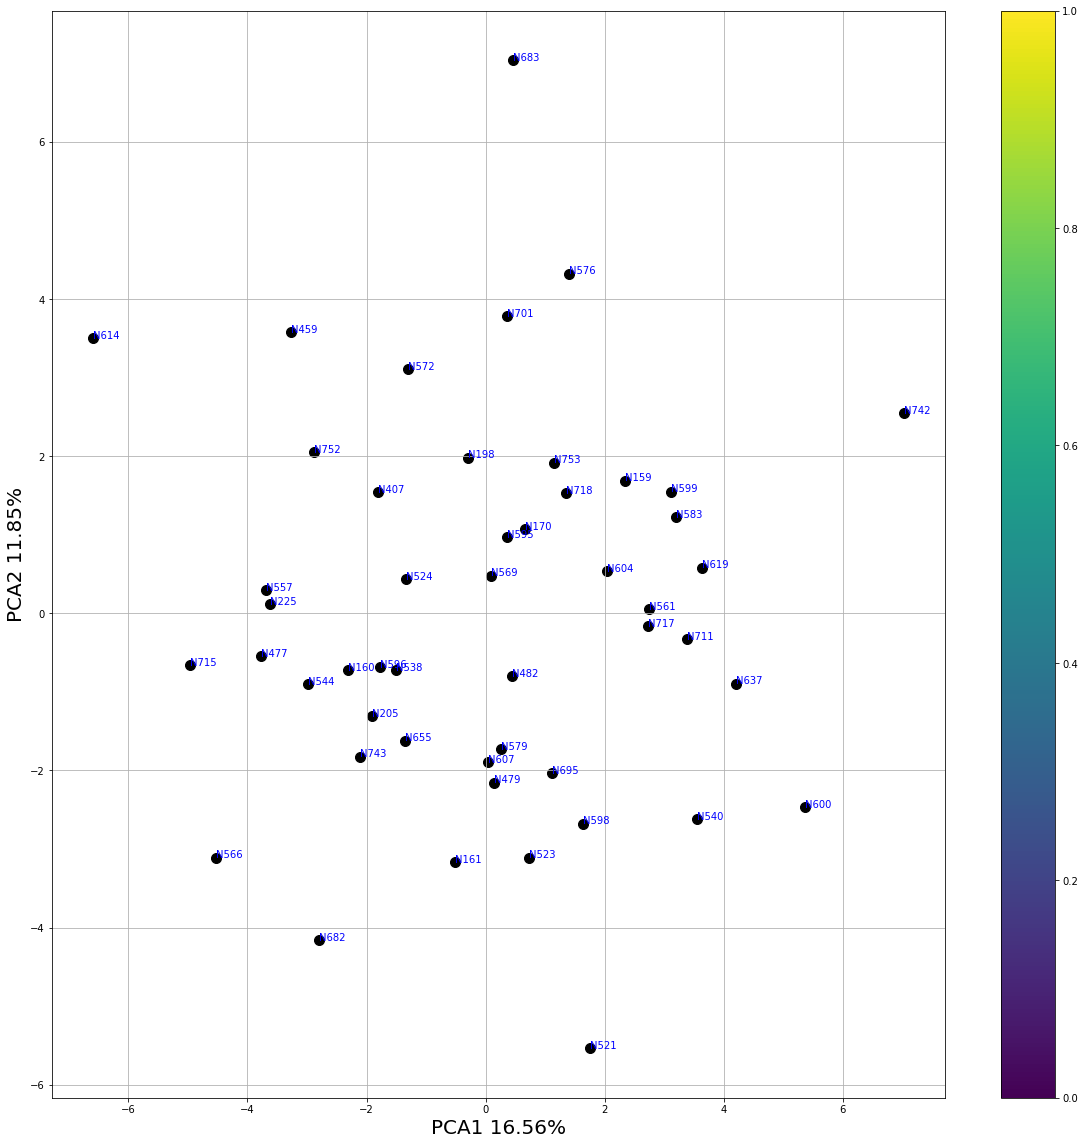

In [360]:
reducer = PCA()
X1p_PCA = reducer.fit_transform(Xs)
plt.figure(figsize=(20,20))
plt.scatter(X1p_PCA[:,0],X1p_PCA[:,1],c='k',s=100)
for k,t in enumerate(patient_ids):
    plt.text(X1p_PCA[k,0],X1p_PCA[k,1],t,color='blue')
plt.title('')
plt.xlabel('PCA1 {:2.2f}%'.format(reducer.explained_variance_ratio_[0]*100),fontsize=20)
plt.ylabel('PCA2 {:2.2f}%'.format(reducer.explained_variance_ratio_[1]*100),fontsize=20)
plt.colorbar()
plt.grid('on')
plt.show()

set()


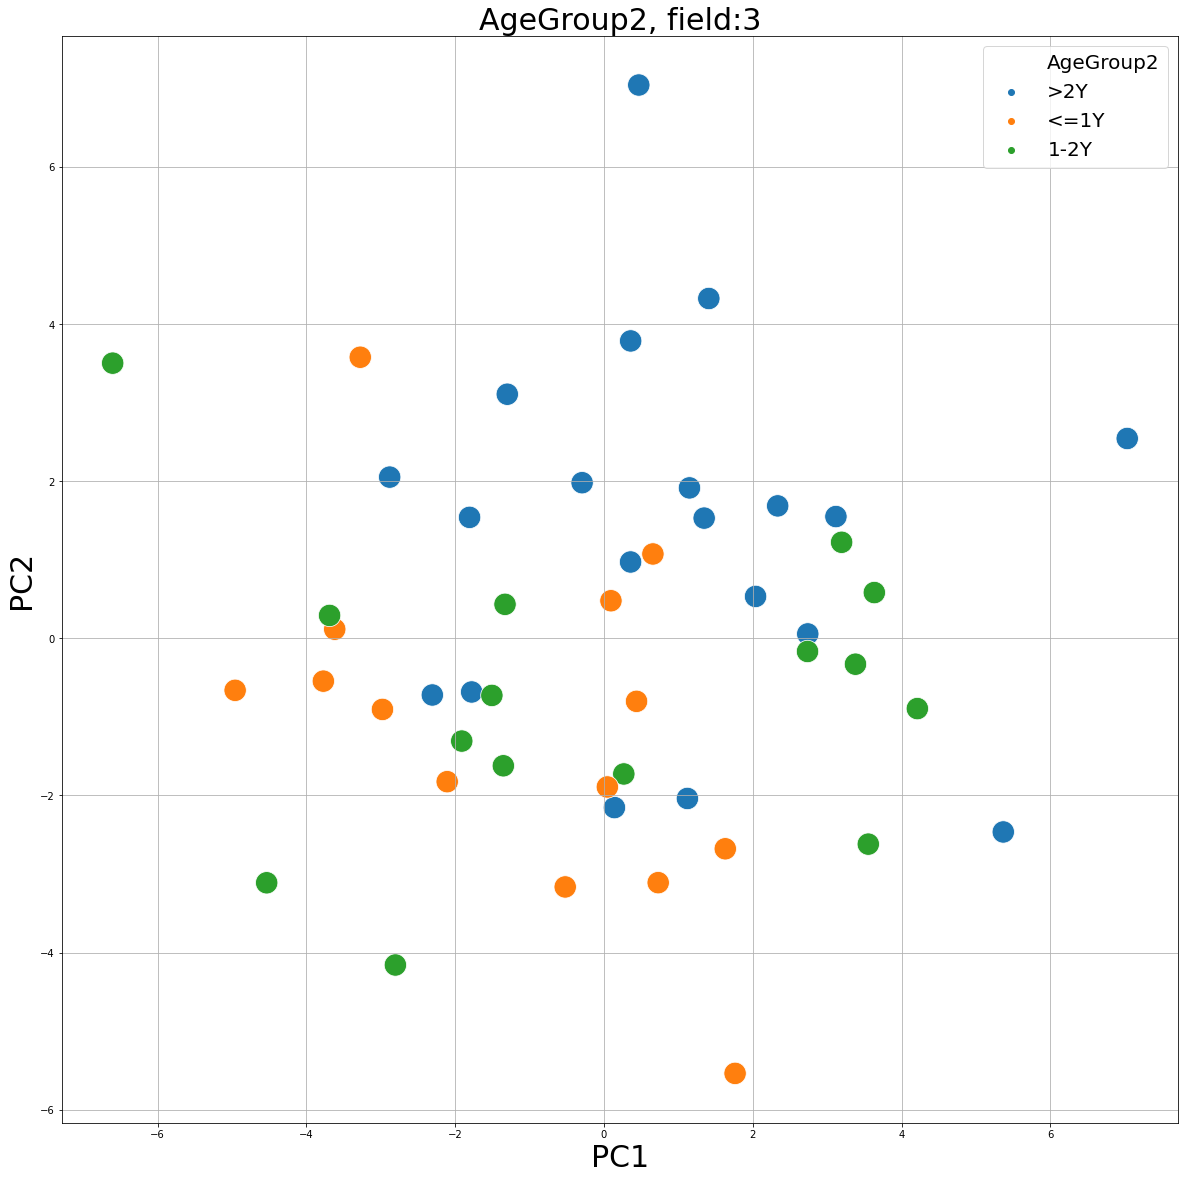

In [361]:
patient_info = pd.read_csv(folder+patient_info_fn,sep='\t')
patient_list = list(patient_info.Patient)
print(set(patient_ids)-set(patient_list))
inds = ismember(patient_ids,patient_list)
patient_info = patient_info.iloc[inds]
#display(patient_info)

df1 = patient_info.copy()
df1['PC1'] = X1p_PCA[:,0]
df1['PC2'] = X1p_PCA[:,1]
fd = 3
plt.figure(figsize=(20,20))
sns.scatterplot(data=df1,x='PC1',y='PC2',hue=df1.columns[fd],s=500)
plt.legend(fontsize=20)
plt.xlabel('PC1',fontsize=30)
plt.ylabel('PC2',fontsize=30)
plt.title(f'{df1.columns[fd]}, field:{fd}',fontsize=30)
plt.grid('on')
plt.show()

In [7]:
# Survival analysis, univariate

from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

fn = 'ica_decompositions/MultiICA_signature_scores_extended'
score_patients = pd.read_csv(folder_analysis+fn+'.txt',sep='\t')

patient_info = pd.read_csv(folder+patient_info_fn,sep='\t')
#display(score_patients)

patient_ids = np.array(score_patients[score_patients.columns[0]])

df_result = pd.DataFrame()

analysis_type = 'overall'
#analysis_type = 'progrfree'
if analysis_type=='overall':
    col_event = 'NTI_event_overall'
    col_followup = 'NTI_surv_overall'
if analysis_type=='progrfree':
    col_event = 'NTI_event_progrfree'
    col_followup = 'NTI_surv_progrfree'

for comp in score_patients.columns[1:]:
    scores = score_patients[comp]
    scores = pd.DataFrame(scores[~np.isnan(scores.to_numpy())])
    #display(scores)
    pats = patient_ids[list(scores.index)]
    #print(pats)
    inds = ismember(pats,list(patient_info['Patient']))
    pat_info = patient_info.iloc[inds]
    l = list(pat_info[col_event])
    l1 = []
    for ll in l:
        if ll=='yes':
            l1.append(1)
        else:
            l1.append(0)
    scores[col_event] = l1
    scores[col_followup] = list(pat_info[col_followup])
    scores1 = scores.dropna(axis = 0, how ='any', thresh = None, subset = None, inplace=False)    
    cph = CoxPHFitter()
    cph.fit(scores1, duration_col=col_followup, event_col=col_event)
    #print('==============================  '+comp+'  ==============================')
    #cph.print_summary()
    #print('=======================================================================\n\n')
    zval = float(cph.summary['z'])
    pval = float(cph.summary['p'])
    df_result[comp] = [zval,pval]
    
df_result = df_result.T
df_result.columns = ['zval','pval']
df_result = df_result.sort_values(by=['pval'])

print(df_result)

df_result.to_csv(folder_analysis+'ica_decompositions/MultiICA_survival_'+analysis_type+'.txt',sep='\t')
    

                 zval          pval
CL_MRPL54    5.060396  4.183876e-07
CL_CCT5      4.644622  3.406990e-06
CL_PCDHA1   -4.154237  3.263750e-05
CL_ZNF689    4.038745  5.373801e-05
CL_MAP7     -4.013742  5.976370e-05
...               ...           ...
CL_MORC3    -0.167743  8.667856e-01
CL_LCN10     0.099867  9.204495e-01
CL_WDR61     0.055228  9.559565e-01
CL_SCGB1D1   0.049486  9.605320e-01
CL_PPP1R14D  0.011323  9.909659e-01

[93 rows x 2 columns]


<lifelines.CoxPHFitter: fitted with 56 total observations, 30 right-censored observations>
             duration col = 'NTI_surv_progrfree'
                event col = 'NTI_event_progrfree'
      baseline estimation = breslow
   number of observations = 56
number of events observed = 26
   partial log-likelihood = -94.43
         time fit was run = 2022-05-12 18:14:12 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CL_AHRR    -0.44       0.65       0.25            -0.92             0.05                 0.40                 1.05

              z    p   -log2(p)
covariate                      
CL_AHRR   -1.76 0.08       3.68
---
Concordance = 0.64
Partial AIC = 190.87
log-likelihood ratio test = 3.37 on 1 df
-log2(p) of ll-ratio test = 3.91

covariate
CL_AHRR   -0.435647
Name: coef, dtype: float64
-0.01434713909162678


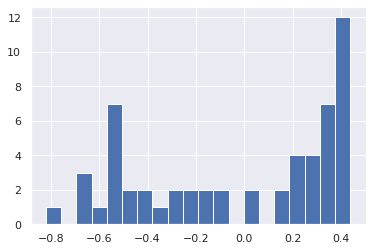

Optimal threshold= 0.0


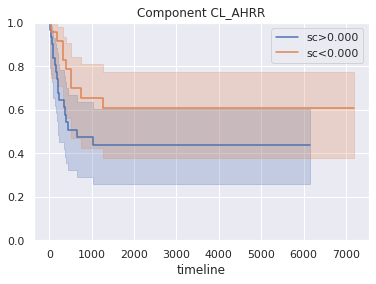

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.53 0.11      3.16

p-value= 0.11205314006873617 -log2= 3.1577450167832


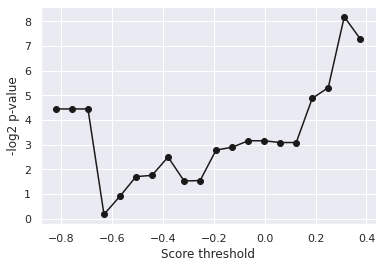

In [152]:
# Survival analysis, multivariate

#comps = ['CL_POLR2E','CL_PCDHA1','CL_DVL2']
#comps = ['CL_KIF20A']
#comps = ['CL_PCDHA1']
#comps = ['CL_DVL2']
#comps = ['CL_VEGFB']
#comps = ['CL_IFNA4']
#comps = ['CL_POLR2E','CL_PCDHA1','CL_DVL2','CL_VEGFB','CL_KIF20A','CL_GFRA4','CL_LRRC47','CL_UGT1A1','CL_FRMD8','CL_YTHDF1']
#comps = ['CL_MRPL54']
#comps = ['CL_ABCE1']
#comps = ['CL_PCDHA1']
#comps = ['CL_MAP7']
#comps = ['CL_LRRC47']
#comps = ['CL_ATPAF2']
#comps = ['CL_CCNB2'] # cell cycle
#comps = ['CL_MRPL54','CL_ABCE1','CL_ZNF689']
#comps = ['CL_MRPL54','CL_ABCE1']
#comps = ['CL_ATPAF2']
#comps = ['CL_HIVEP1']
#comps = ['CL_EEF2K']
#comps = ['CL_IFNA4']
#comps = ['CL_MED17']
#comps = ['CL_AHRR']
#comps = ['CL_CCT5']
#comps = ['CL_KRT35']
#comps = ['CL_MAP7']
#comps = ['CL_MRPL54','CL_ABCE1','CL_ZNF689','CL_PCDHA1','CL_MAP7','CL_IFNA4','CL_C2orf44','CL_EEF2K','CL_HIVEP1','CL_ABCA7','CL_CCNB2','CL_TGM6','CL_CST8']
#comps = ['CL_PCDHA1','CL_EEF2K','CL_C2orf44']
comps = ['CL_AHRR']



fn = 'ica_decompositions/MultiICA_signature_scores_extended'
score_patients = pd.read_csv(folder_analysis+fn+'.txt',sep='\t')

patient_info = pd.read_csv(folder+patient_info_fn,sep='\t')
#display(score_patients)

patient_ids = np.array(score_patients[score_patients.columns[0]])

analysis_type = 'overall'
analysis_type = 'progrfree'
if analysis_type=='overall':
    col_event = 'NTI_event_overall'
    col_followup = 'NTI_surv_overall'
if analysis_type=='progrfree':
    col_event = 'NTI_event_progrfree'
    col_followup = 'NTI_surv_progrfree'

scores = pd.DataFrame(score_patients[comps])
#display(scores)
pats = patient_ids[list(scores.index)]
#print(pats)
inds = ismember(pats,list(patient_info['Patient']))
pat_info = patient_info.iloc[inds]
l = list(pat_info[col_event])
l1 = []
for ll in l:
    if ll=='yes':
        l1.append(1)
    else:
        l1.append(0)
scores[col_event] = l1
scores[col_followup] = list(pat_info[col_followup])
scores1 = scores.dropna(axis = 0, how ='any', thresh = None, subset = None, inplace=False)    
cph = CoxPHFitter()
cph.fit(scores1, duration_col=col_followup, event_col=col_event)
cph.print_summary()

from lifelines import KaplanMeierFitter

print(cph.summary['coef'])
vec = np.array(cph.summary['coef'])
xx = np.array(scores1[comps])
sc = vec@xx.T
print(np.mean(sc))
plt.hist(sc,bins=20)
plt.show()

#comp = comps[0]
#display(scores1)
#print(np.mean(scores1[comp]))
#plt.hist(scores1[comp],bins=20)
#plt.show()

kmf = KaplanMeierFitter()

ax = plt.subplot(111)

#sc = scores1[comp]
#dm = sc>np.mean(sc)

dm_thresh = np.arange(np.min(sc),np.max(sc),(np.max(sc)-np.min(sc))/20)
log2_p_values = []
for dmt in dm_thresh:
    dm = sc>dmt
    results = logrank_test(scores1[col_followup][dm], scores1[col_followup][~dm], scores1[col_event][dm], scores1[col_event][~dm], alpha=.99)
    log2_p_values.append(-np.log2(results.p_value))
    


thresh = dm_thresh[np.argmax(log2_p_values)]
thresh = 0.0
print('Optimal threshold=',thresh)
dm1 = sc>thresh


kmf.fit(scores1[col_followup][dm1], event_observed=scores1[col_event][dm1], label='sc>{:2.3f}'.format(thresh))
kmf.plot_survival_function(ax=ax)

kmf.fit(scores1[col_followup][~dm1], event_observed=scores1[col_event][~dm1], label='sc<{:2.3f}'.format(thresh))
kmf.plot_survival_function(ax=ax)


#kmf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
#kmf.plot_survival_function(ax=ax)

plt.title('Component '+'/'.join(comps))
plt.ylim([0,1])
plt.show()

results = logrank_test(scores1[col_followup][dm1], scores1[col_followup][~dm1], scores1[col_event][dm1], scores1[col_event][~dm1], alpha=.99)
results.print_summary()
print('p-value=',results.p_value,'-log2=',-np.log2(results.p_value))

plt.plot(dm_thresh,log2_p_values,'ko-')
plt.xlabel('Score threshold')
plt.ylabel('-log2 p-value')
plt.grid('on')
plt.show()

In [ ]:
for comp in score_patients.columns[1:]:
    scores = score_patients[comp]
    scores = pd.DataFrame(scores[~np.isnan(scores.to_numpy())])


<Figure size 1440x1440 with 0 Axes>

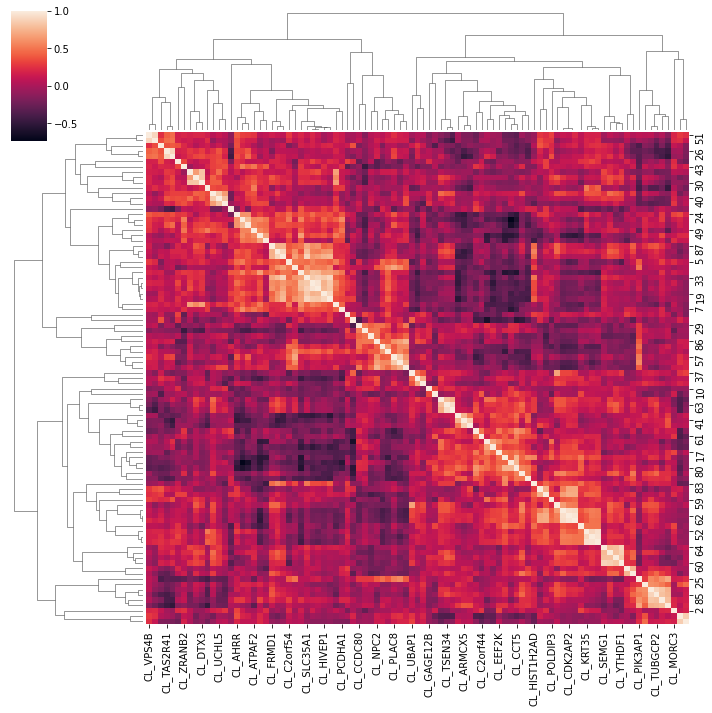

In [53]:
dfms = pd.read_csv('/mnt/c/Datas/BIODICA_GUI/work/NBAMC_multiICA_MSAMPLE/NBAMC_multiICA_A_annot.xls',sep='\t')
df = pd.read_csv('/mnt/c/Datas/BIODICA_GUI/work/NBAMC_multiICA_MSAMPLE/NBAMC_multiICA_A_associations_slf_info.xls',sep='\t')
df = df[df.columns[:-1]]
dfn = df[df.columns[1:94]]
#display(dfn)
fig = plt.figure(figsize=(20,20))
g = sns.clustermap(dfn,metric='correlation',row_cluster=True,)

In [59]:
dfms = dfms[dfms.columns[:-1]]
dfmsn = dfms[dfms.columns[1:94]]


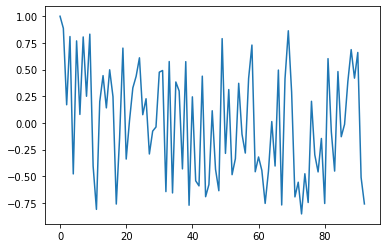

[73 11 39 67 17 92 80 62 75 71 44 34 32 48 42 45 72 41 91 52  4 74 78 59
 83 63 61 47 37 10 65 20 53 60 77 27 50 56 79 18 85 55 82 28 29 86 64 21
 25  6 46 14  2 12 76 26 40 16  8 70 36 51 22 54 35 87 68 57 89 23 43 13
 30 84 31 66 15 38 33 81 24 90 88 19 58  5 49  7  3  9 69  1  0]


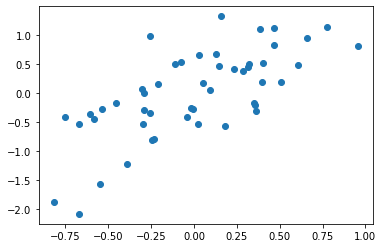

In [74]:
cr = np.corrcoef(dfn.to_numpy())
plt.plot(cr[:,0])
plt.show()
print(np.argsort(cr[:,0]))
dfmsn_n = dfmsn.to_numpy()
plt.scatter(dfmsn_n[:,0],dfmsn_n[:,1])

<Figure size 1440x1440 with 0 Axes>

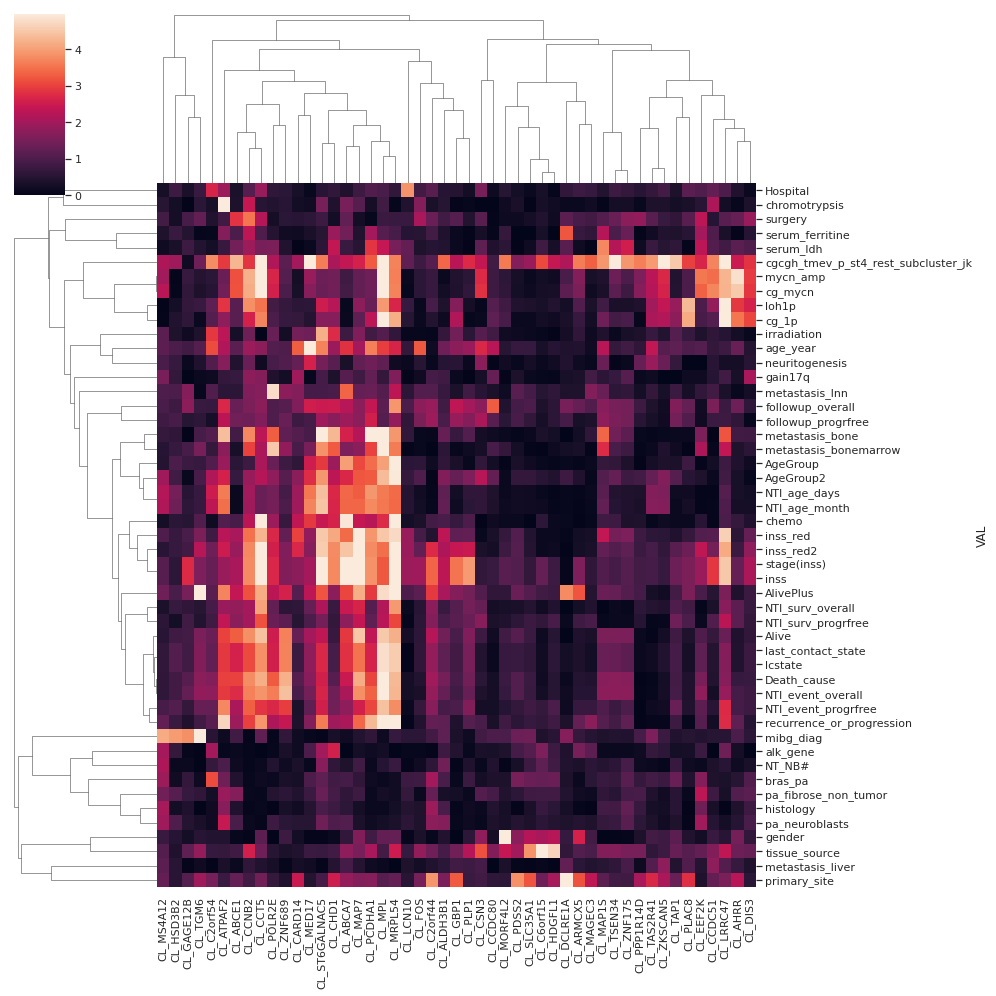

In [137]:
from scipy.stats.mstats import winsorize
dfpv = pd.read_csv('/mnt/c/Datas/BIODICA_GUI/work/NBAMC_multiICA_MSAMPLE/temp.xls',sep='\t')
dfpv = dfpv[dfpv.columns[:-1]]
val = dfpv.pop('VAL')
dfpv.index = val
dfpv = dfpv
mat = winsorize(dfpv.to_numpy(),limits=[0, 0.01])
irx = np.where(np.max(mat,axis=0)>3.0)[0]
#print(irx)
#display(dfpv)
dfpv = pd.DataFrame(data=mat[:,irx],index=val,columns=dfpv.columns[irx])

fig = plt.figure(figsize=(20,20))
sns.set(font_scale=1.0)
#g = sns.clustermap(dfpv,metric='correlation',row_cluster=True,figsize=(14,30))
g = sns.clustermap(dfpv,metric='correlation',row_cluster=True,figsize=(14,14))

<AxesSubplot:xlabel='alk_gene', ylabel='CL_CHD1'>

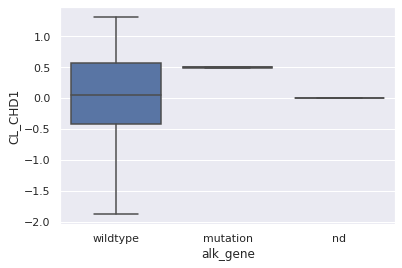

In [158]:
sns.boxplot(data=dfms,x='alk_gene',y='CL_CHD1')